In [363]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
import chardet
import json
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## used ports in idle dataset

In [2]:
with open('nmap_dataset/NEU/port_info.json') as f:
    data = json.load(f)

In [3]:
traffic_df = pd.DataFrame(columns=['device', 'protocol', 'port'])

for device, protocols in data.items():
    for protocol, ports in protocols.items():
            traffic_df = traffic_df.append({'device': device, 'protocol': protocol, 'port': ports}, ignore_index=True)

In [4]:
traffic_df

device          protocol  \
0     echodot3c               tls   
1     echodot3c               tcp   
2     echodot3c               udp   
3     echodot3c  tplink-smarthome   
4     echodot3c              ssdp   
..          ...               ...   
305  echodot3uk               udp   
306  echodot3uk              ssdp   
307  echodot3uk  tplink-smarthome   
308  echodot3uk              dhcp   
309  echodot3uk              mdns   

                                                  port  
0    [60648, 41678, 45930, 55376, 60168, 52740, 414...  
1    [60648, 45930, 36954, 55376, 37524, 36192, 554...  
2    [50000, 50035, 50028, 50022, 50029, 50025, 500...  
3    [50035, 50028, 50022, 50029, 50025, 50021, 500...  
4                                              [50000]  
..                                                 ...  
305  [50000, 50035, 50028, 50022, 50029, 50025, 500...  
306                                            [50000]  
307  [50035, 50028, 50022, 50029, 50025, 50021, 500...  
308                                               [68]  
309                                             [5353]  

[310 rows x 3 columns]

## Device list

In [5]:
with open('nmap_dataset/NEU/ip_list.json') as f:
    data = json.load(f)

data_list = [{"ip_addr": "192.168.10." + key, "device": next(iter(value))} for key, value in data.items()]

In [6]:
device_df = pd.DataFrame(data_list)

In [909]:
device_df[device_df['device'] == 'homepod-mini1']

ip_addr         device
83  192.168.10.190  homepod-mini1

## Read JSON and convert to dataframe

In [8]:
def json_to_dataframe(out_dict):
    column_names = [
    'scanner', 'args', 'start_time', 'start_time_str', 'version', 'xmloutputversion',
    'verbose', 'hosts_up', 'hosts_down', 'hosts_total', 'ip_addr', 'mac_addr', 'vendor',
    'protocol', 'port_id', 'state', 'reason', 'service', 'service_version']

    df = pd.DataFrame(columns=column_names)

    scanner = out_dict['nmaprun']['@scanner']
    args = out_dict['nmaprun']['@args']
    start_time = out_dict['nmaprun']['@start']
    start_time_str = out_dict['nmaprun']['@startstr']
    version = out_dict['nmaprun']['@version']
    xmloutputversion = out_dict['nmaprun']['@xmloutputversion']
    verbose = out_dict['nmaprun']['verbose']['@level']
    hosts_up = out_dict['nmaprun']['runstats']['hosts']['@up']
    hosts_down = out_dict['nmaprun']['runstats']['hosts']['@down']
    hosts_total = out_dict['nmaprun']['runstats']['hosts']['@total']

    hosts = out_dict['nmaprun']['host']
    if not isinstance(hosts, list):
        hosts = [hosts]

    for host in hosts:
        ip_addr = ''
        mac_addr = ''
        vendor = ''
        address = host['address']
        if isinstance(address, list):
            for addr_item in address:
                if addr_item['@addrtype'] == 'ipv4':
                    ip_addr = addr_item['@addr']
                elif addr_item['@addrtype'] == 'mac':
                    mac_addr = addr_item['@addr']
                    vendor = addr_item.get('@vendor', '')
        else:
            ip_addr = address['@addr']

        ports_data = host.get('ports', {})
        if 'port' in ports_data:
            ports = ports_data['port']
            if not isinstance(ports, list):
                ports = [ports]
            for port in ports:
                protocol = port['@protocol']
                port_id = port['@portid']
                state = port['state']['@state']
                reason = port['state']['@reason']
                service = 'unknown'
                service_version = 'unknown'
                if 'service' in port:
                    service = port['service']['@name']
                    if '@product' in port['service']:
                        service_version = port['service']['@product'] + ' ' + port['service'].get('@version', 'unknown')
                row = {
                    'scanner': scanner,
                    'args': args,
                    'start_time': start_time,
                    'start_time_str': start_time_str,
                    'version': version,
                    'xmloutputversion': xmloutputversion,
                    'verbose': verbose,
                    'hosts_up': hosts_up,
                    'hosts_down': hosts_down,
                    'hosts_total': hosts_total,
                    'ip_addr': ip_addr,
                    'mac_addr': mac_addr,
                    'vendor': vendor,
                    'protocol': protocol,
                    'port_id': port_id,
                    'state': state,
                    'reason': reason,
                    'service': service,
                    'service_version': service_version
                }
                df = df.append(row, ignore_index=True)
    return df

## Some stats 

In [251]:
print("unique TCP ports in the dataset {}".format(df_nmap_tcp['port_id'].nunique()))
print("unique UDP ports in the dataset {}".format(df_nmap_udp['port_id'].nunique()))

unique TCP ports in the dataset 178
unique UDP ports in the dataset 115


## TCP

In [135]:
tcp_part_one = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-p_1-65535_-sS_-sV_-T4_--reason_-iL_part_1_--exclude_192.168.10.243_2023-04-23_10-53-23.json'
tcp_part_two = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-p_1-65535_-sS_-sV_-T4_--reason_-iL_part_2_--exclude_192.168.10.243_2023-04-23_15-11-27.json'

In [136]:
with open(tcp_part_one) as f:
    data_one = json.load(f)

In [137]:
with open(tcp_part_two) as f:
    data_two = json.load(f)

In [138]:
df_one = json_to_dataframe(data_one)
df_two = json_to_dataframe(data_two)
df = pd.concat([df_one, df_two])

In [139]:
df_nmap_tcp = df.merge(device_df[['device', 'ip_addr']], on='ip_addr', how='left')

------

In [701]:
ip_proto_one = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-sO_-T4_--reason_-iL_part_2_-exclude_192.168.10.243_-v_2023-04-23_18-50-18.json'
ip_proto_two = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-sO_-T4_--reason_-iL_part_1_-exclude_192.168.10.243_-v_2023-04-23_19-01-16.json'

In [702]:
with open(ip_proto_one) as f:
    data_one = json.load(f)

with open(ip_proto_two) as f:
    data_two = json.load(f)

df_one = json_to_dataframe(data_one)
df_two = json_to_dataframe(data_two)

df_ipproto = pd.concat([df_one, df_two])

In [704]:
df_ipproto.ip_addr.nunique()

58

## UDP

In [231]:
udp_one = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-p_1-1024_-sU_-sV_-T4_--reason_-iL_part_2_--exclude_192.168.10.243_2023-04-23_20-32-01.json'
udp_two = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-p_1-1024_-sU_-sV_-T4_--reason_-iL_part_1_split_2_--exclude_192.168.10.243_2023-04-30_09-30-46.json'
udp_three = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-p_1-1024_-sU_-sV_-T4_--reason_-iL_part_1_split_--exclude_192.168.10.243_2023-04-30_09-28-45.json'

In [232]:
with open(udp_one) as f:
    data_one = json.load(f)

with open(udp_two) as f:
    data_two = json.load(f)
    
with open(udp_three) as f:
    data_three = json.load(f)

In [233]:
df_one = json_to_dataframe(data_one)
df_two = json_to_dataframe(data_two)
df_three = json_to_dataframe(data_three)

df = pd.concat([df_one, df_two, df_three])

In [234]:
df_nmap_udp = df.merge(device_df[['device', 'ip_addr']], on='ip_addr', how='left')

In [246]:
## Based on ports
grouped_ports = df_nmap_udp.groupby('device')['port_id'].apply(list).reset_index()

grouped_ports['port_id'] = grouped_ports['port_id'].apply(tuple)

# Group by the 'open_ports' column and aggregate the devices into a list
grouped_df = grouped_ports.groupby('port_id')['device'].apply(list).reset_index()

# Convert the tuples in the 'open_ports' column back to lists
grouped_df['port_id'] = grouped_df['port_id'].apply(list)

grouped_df['device'] = grouped_df['device'].apply(lambda x: x[0] if len(x) == 1 else x)

# # Remove the square brackets from the 'open_ports' column
# grouped_df['port_id'] = grouped_df['port_id'].apply(lambda x: ', '.join(map(str, x)))

grouped_df = grouped_df[['device', 'port_id']]

In [247]:
latex_table = grouped_df.to_latex(index=False)

In [248]:
print(latex_table)

\begin{tabular}{ll}
\toprule
                        device &                                                                                        port\_id \\
\midrule
nest-camera & [157, 184, 421, 466, 607, 617, 676, 712, 803, 807, 856, 874] \\
smartthings-hub & [300] \\
google-home-mini & [342, 577, 735, 833, 925] \\
ring-indoor-cam & [35, 204, 240, 346, 745, 898, 907, 1000] \\
wyze-cam & [40, 56, 106, 182, 205, 267, 343, 472, 475, 560, 622, 714, 737, 792, 823, 874] \\
sengled-hub-spoofed & [425, 501] \\
echoshow5 & [443] \\
[homepod-mini1, homepod-mini2] & [53, 319, 320, 546] \\
fridge & [53, 68, 100, 642, 722, 906] \\
t-philips-hub & [594, 611] \\
google-nest-mini2 & [6, 36, 137, 259, 439, 467, 560, 569, 855, 933] \\
roku-tv & [61, 68, 129, 134, 186, 308, 319, 320, 345, 366, 486, 585, 639, 689, 824] \\
google-home-mini2 & [62, 293, 507, 652, 850] \\
pixel3b & [63, 64, 99, 600, 678, 722, 774, 818, 856, 920, 955, 987] \\
ikea-hub & [68] \\
arlo-q-cam & [68, 729] \\
facebook-portal-

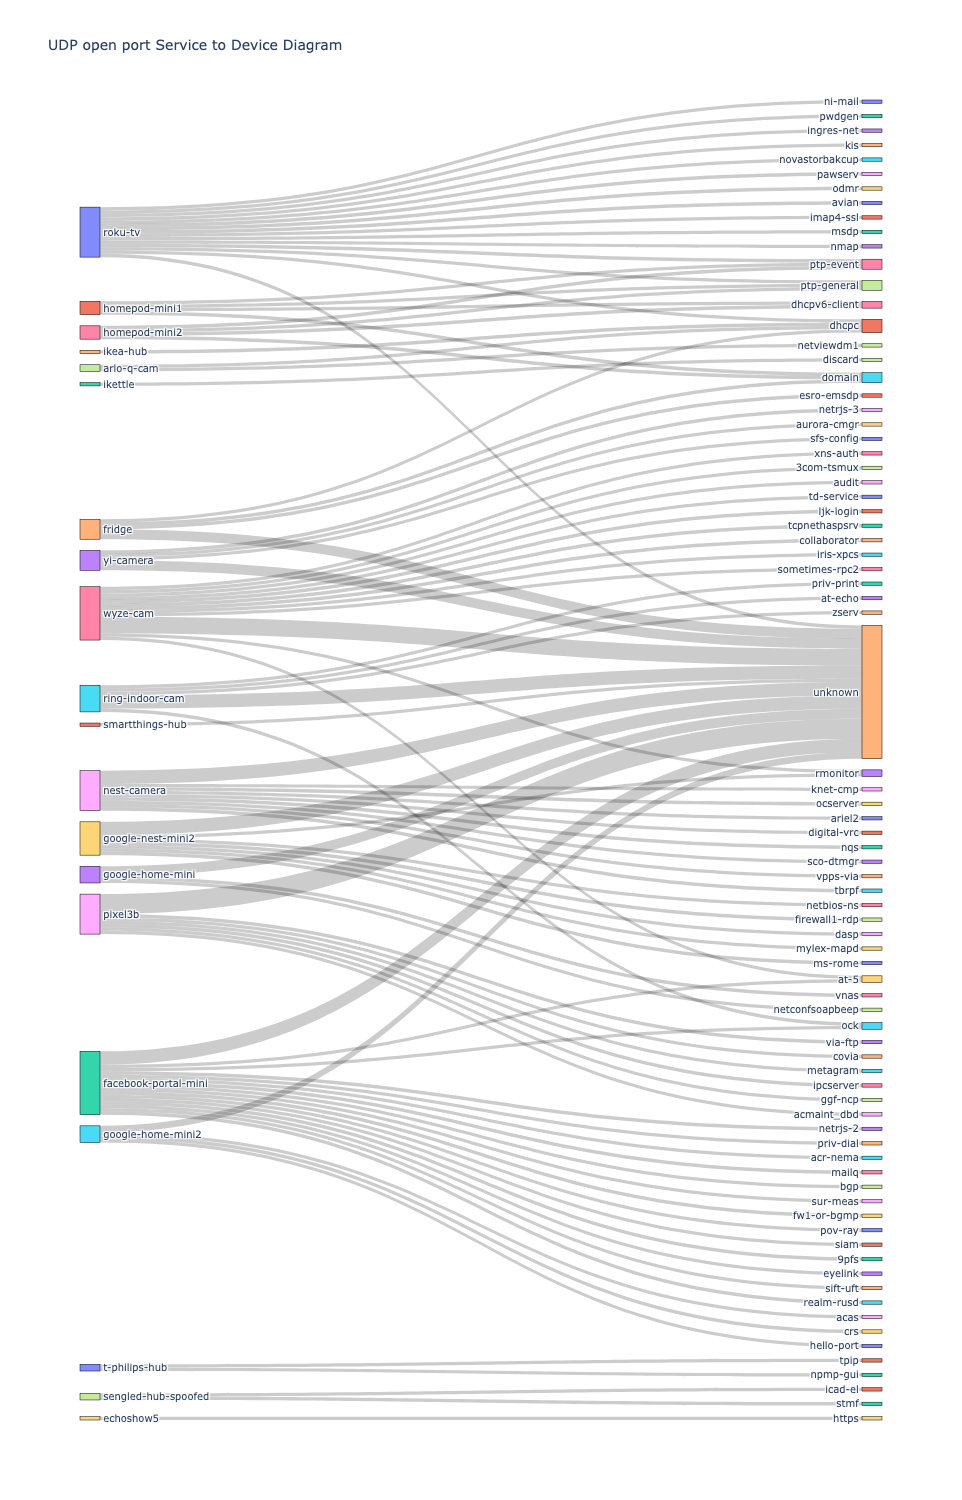

In [242]:
source = df_nmap_udp['service'].unique().tolist()
target = df_nmap_udp['device'].unique().tolist()
labels = source + target

connections = df_nmap_udp.groupby(['service', 'device']).size().reset_index(name='value')

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=.5),
        label=labels,
    ),
    link=dict(
        source=[labels.index(conn['device']) for _, conn in connections.iterrows()],
        target=[source.index(conn['service']) for _, conn in connections.iterrows()],
        value=connections['value'].tolist(),
        # color=flow_line_colors,
    )
)])

fig.update_layout(title_text="UDP open port Service to Device Diagram", font_size=10, height=1500)
fig.show()
# fig.write_image('tcp_services_sankey.pdf')

In [941]:
df_nmap[['service', 'protocol', 'port_id', 'device']].to_csv('neu_nmap_ports.csv', index=False)

In [844]:
df_nmap['active_service'] = df_nmap['service'] + '/' + df_nmap['port_id'].astype(str)


In [869]:
df_nmap.to_csv("df_nmap_neu.csv", index=False)

In [952]:
port_counts = df_nmap.groupby('device')['port_id'].nunique()
service_counts = df_nmap.groupby('device')['service'].nunique()

avg_ports_per_device = port_counts.mean()
avg_services_per_device = service_counts.mean()

print("avg ports per devices {}".format(avg_ports_per_device))
print("avg services per devices {}".format(avg_services_per_device))

avg ports per devices 7.508196721311475
avg services per devices 4.655737704918033


In [962]:
tf = df_nmap[['service', 'protocol', 'port_id', 'device']]

In [965]:
tf[tf['service'] == 'http']

service protocol port_id               device
3    http    tcp      8008    google-home-mini2  
47   http    tcp      8009    echoshow8          
48   http    tcp      38110   echoshow8          
52   http    tcp      60000   echoshow8          
53   http    tcp      80      sengled-hub-spoofed
78   http    tcp      80      microseven-camera  
82   http    tcp      80      meross-dooropener  
83   http    tcp      80      meross-plug2       
89   http    tcp      8009    echoshow5          
92   http    tcp      45761   echoshow5          
95   http    tcp      60000   echoshow5          
96   http    tcp      8009    firetv             
97   http    tcp      53052   firetv             
99   http    tcp      60000   firetv             
105  http    tcp      8008    nest-hub-max       
119  http    tcp      8008    google-nest-mini2  
128  http    tcp      80      t-philips-hub      
129  http    tcp      443     t-philips-hub      
130  http    tcp      8080    t-philips-hub      
131  http    tcp      80      meross-plug1       
157  http    tcp      8008    google-home-mini   
171  http    tcp      80      wansview-cam-wired 
172  http    tcp      554     wansview-cam-wired 
213  http    tcp      8008    nest-hub           
249  http    tcp      8008    tivostream         
284  http    tcp      80      lefun-cam-wired    
298  http    tcp      8008    google-nest-mini1  
315  http    tcp      80      tplink-tapo-plug   
316  http    tcp      80      amcrest-cam-wired

In [948]:
avg_ports_per_device

7.508196721311475

In [949]:
avg_services_per_device

4.655737704918033

In [944]:
df_nmap[df_nmap['service'] == 'upnp']

scanner  \
189  nmap     
288  nmap     
319  nmap     
322  nmap     

                                                                                    args  \
189  nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_2 --exclude 192.168.10.243 nmap   
288  nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_2 --exclude 192.168.10.243 nmap   
319  nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_2 --exclude 192.168.10.243 nmap   
322  nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_2 --exclude 192.168.10.243 nmap   

     start_time            start_time_str version xmloutputversion verbose  \
189  1682262687  Sun Apr 23 15:11:27 2023  7.80    1.04             0        
288  1682262687  Sun Apr 23 15:11:27 2023  7.80    1.04             0        
319  1682262687  Sun Apr 23 15:11:27 2023  7.80    1.04             0        
322  1682262687  Sun Apr 23 15:11:27 2023  7.80    1.04             0        

    hosts_up hosts_down hosts_total  ...           mac_addr  \
189  29       16         45          ...  88:DE:A9:08:03:B9   
288  29       16         45          ...  14:91:82:B4:4B:5F   
319  29       16         45          ...  9C:8E:CD:0A:33:1B   
322  29       16         45          ...  9C:8E:CD:0A:33:1B   

                   vendor protocol port_id state   reason service  \
189  Roku                  tcp      8060    open  syn-ack  upnp     
288  Belkin International  tcp      49153   open  syn-ack  upnp     
319  Amcrest Technologies  tcp      5000    open  syn-ack  upnp     
322  Amcrest Technologies  tcp      49152   open  syn-ack  upnp     

    service_version             device active_service  
189  unknown         roku-tv            upnp/8060      
288  unknown         t-wemo-plug        upnp/49153     
319  unknown         amcrest-cam-wired  upnp/5000      
322  unknown         amcrest-cam-wired  upnp/49152     

[4 rows x 21 columns]

In [906]:
aa = df_nmap[['device', 'protocol', 'service', 'port_id', 'active_service']]

In [900]:
aa[aa['service'] == 'ptp-general']

device protocol      service port_id   active_service  \
15   roku-tv        udp      ptp-general  320     ptp-general/320   
34   homepod-mini1  udp      ptp-general  320     ptp-general/320   
230  homepod-mini2  udp      ptp-general  320     ptp-general/320   

    active_device  
15   NaN           
34   NaN           
230  NaN

In [902]:
aa[aa['service'] == 'domain']

device protocol service port_id active_service active_device
30   homepod-mini1  udp      domain  53      domain/53      NaN         
52   fridge         udp      domain  53      domain/53      NaN         
74   homepod-mini2  tcp      domain  53      domain/53      NaN         
76   homepod-mini2  tcp      domain  853     domain/853     NaN         
226  homepod-mini2  udp      domain  53      domain/53      NaN         
326  homepod-mini1  tcp      domain  53      domain/53      NaN         
327  homepod-mini1  tcp      domain  853     domain/853     NaN         
419  t-wemo-plug    tcp      domain  53      domain/53      NaN

In [896]:
plot_counts

service
ajp13            7 
at-5             2 
cslistener       7 
dhcpc            4 
dhcpv6-client    2 
domain           4 
ezmeeting-2      8 
http             20
https-alt        7 
irc              5 
mvs-capacity     6 
nagios-nsca      12
ock              2 
other-tcp        16
other-udp        16
ptp-event        3 
ptp-general      3 
rmonitor         2 
rtsp             8 
rxapi            2 
scp-config       6 
socks5           9 
stel             6 
tcpwrapped       19
upnp             3 
weave            2 
Name: device, dtype: int64

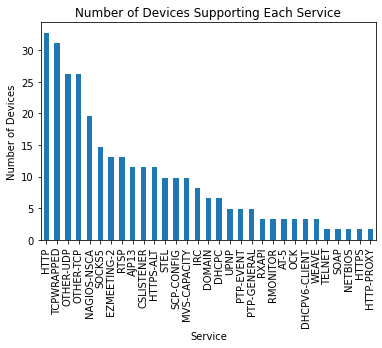

In [898]:
service_counts = aa.groupby('service')['device'].nunique()

# Identify services supported by only one device
single_device_services = service_counts[service_counts == 1].index

# Replace single device service names based on the protocol
aa.loc[(aa['service'].isin(single_device_services)) & (aa['protocol'] == 'tcp'), 'service'] = 'other-tcp'
aa.loc[(aa['service'].isin(single_device_services)) & (aa['protocol'] == 'udp'), 'service'] = 'other-udp'
aa = aa[aa['service'] != 'unknown']

# Calculate counts again for plotting
plot_counts = aa.groupby('service')['device'].nunique()
# Let's say we want to add 5 new items
new_items = pd.Series([1, 1, 1, 1, 1], index=['telnet', 'soap', 'netbios', 'https', 'http-proxy'])

# Append new items to plot_counts
plot_counts = plot_counts.append(new_items)

# Convert service names to capital letters
plot_counts.index = plot_counts.index.str.upper()

# Calculate percentages
plot_counts = (plot_counts / 61) * 100

plot_counts = plot_counts.sort_values(ascending=False)

# Plot
plot_counts.plot(kind='bar')
plt.xlabel('Service')
plt.ylabel('Number of Devices')
plt.title('Number of Devices Supporting Each Service')
plt.show()

In [880]:
aa = df_nmap[['device', 'service']].groupby('service').nunique()
aa = aa.sort_values(by='device', ascending=False)
aa = aa.drop(['unknown'])
aa = aa.drop(['unknown'])


In [931]:
aa

device protocol          service port_id  \
0    echoplus              tcp      nagios-nsca      4070     
1    echoplus              tcp      nagios-nsca      55442    
2    echoplus              tcp      unknown          55443    
3    google-home-mini2     tcp      http             8008     
4    google-home-mini2     tcp      ajp13            8009     
5    google-home-mini2     tcp      unknown          8012     
6    google-home-mini2     tcp      https-alt        8443     
7    google-home-mini2     tcp      cslistener       9000     
8    google-home-mini2     tcp      scp-config       10001    
9    google-home-mini2     tcp      stel             10005    
10   google-home-mini2     tcp      mvs-capacity     10007    
11   google-home-mini2     tcp      ezmeeting-2      10101    
12   echodot5b             tcp      socks5           1080     
13   echodot5b             tcp      nagios-nsca      4070     
14   echodot5b             tcp      tcpwrapped       8888     
15   echodot5b             tcp      nagios-nsca      55442    
16   echodot5b             tcp      unknown          55443    
17   homepod               tcp      rtsp             5000     
18   homepod               tcp      rtsp             7000     
19   homepod               tcp      rtsp             7100     
20   homepod               tcp      unknown          49152    
21   homepod               tcp      unknown          49154    
22   homepod               tcp      rtsp             52834    
23   homepod               tcp      tcpwrapped       62078    
24   tplink-plug           tcp      tcpwrapped       9999     
25   govee-led1            tcp      dlip             7201     
26   govee-led1            tcp      unknown          10661    
27   govee-led1            tcp      unknown          13394    
28   govee-led1            tcp      unknown          27688    
29   govee-led1            tcp      unknown          27872    
30   govee-led1            tcp      unknown          47166    
31   govee-led1            tcp      unknown          61960    
32   echodot4c             tcp      socks5           1080     
33   echodot4c             tcp      nagios-nsca      4070     
34   echodot4c             tcp      tcpwrapped       8888     
35   echodot4c             tcp      nagios-nsca      55442    
36   echodot4c             tcp      unknown          55443    
37   homepod-mini2         tcp      domain           53       
38   homepod-mini2         tcp      domain           853      
39   homepod-mini2         tcp      rtsp             5000     
40   homepod-mini2         tcp      rtsp             7000     
41   homepod-mini2         tcp      rtsp             7100     
42   homepod-mini2         tcp      unknown          49152    
43   homepod-mini2         tcp      unknown          49154    
44   homepod-mini2         tcp      rtsp             54254    
45   homepod-mini2         tcp      unknown          54346    
46   homepod-mini2         tcp      tcpwrapped       62078    
47   echoshow8             tcp      http             8009     
48   echoshow8             tcp      http             38110    
49   echoshow8             tcp      tcpwrapped       43428    
50   echoshow8             tcp      nagios-nsca      55442    
51   echoshow8             tcp      unknown          55443    
52   echoshow8             tcp      http             60000    
53   sengled-hub-spoofed   tcp      http             80       
54   sengled-hub-spoofed   tcp      sun-as-jmxrmi    8686     
55   magichome-strip       tcp      worldfusion1     2595     
56   magichome-strip       tcp      unknown          5577     
57   magichome-strip       tcp      unknown          10287    
58   magichome-strip       tcp      unknown          10507    
59   magichome-strip       tcp      unknown          14081    
60   magichome-strip       tcp      unknown          24026    
61   magichome-strip       tcp      unknown          26683    
62   magichome-strip       tcp      unknown       

In [864]:
# # # set a threshold for the minimum number of devices
# threshold = 2

# # create a mask where 'device' is less than or equal to the threshold
# mask = aa['device'] <= threshold

# # create a new row with 'service' as 'Others' and 'device' as the sum of 'device' where 'device' is less than or equal to the threshold
# others_row = pd.DataFrame({'service': ['Others'], 'device': [aa.loc[mask, 'device'].count()]})

# # remove rows where 'device' is less than or equal to the threshold and append the 'others' row
# aa = aa.loc[~mask].append(others_row)

# aa = aa.sort_values('device', ascending=False)

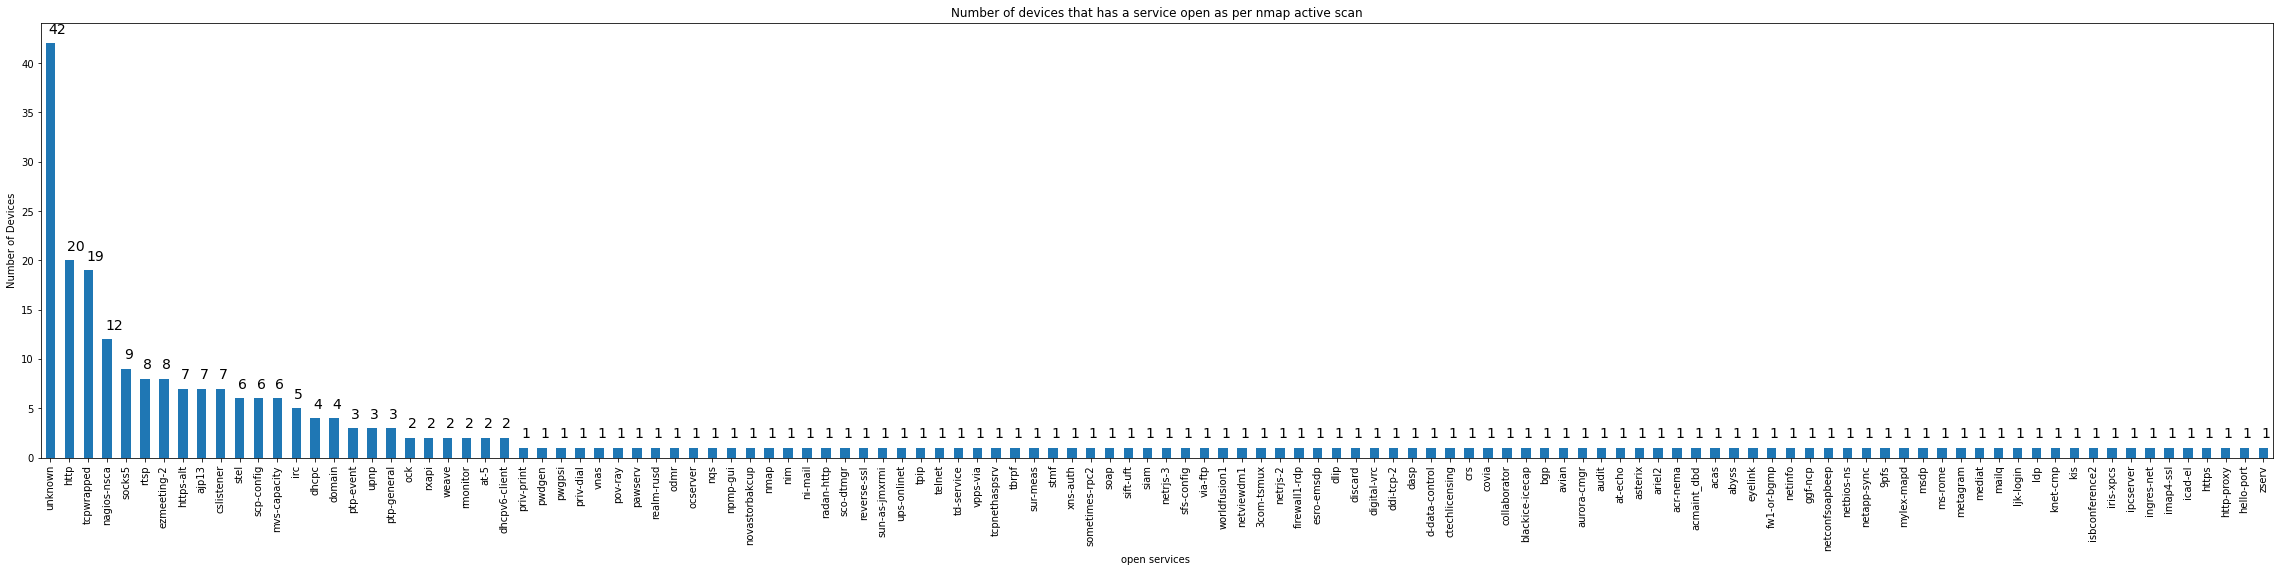

In [872]:
aa = aa.sort_values(by='device', ascending=False)


ax = aa.plot(kind='bar', rot=90, figsize=(40, 8), legend=False)
ax.set_xlabel('open services ')
ax.set_ylabel('Number of Devices')
ax.set_title('Number of devices that has a service open as per nmap active scan')

# Add the numbers on top of each bar
for i, v in enumerate(aa['device']):
    ax.text(i - 0.1, v + 1, str(v), color='black', fontsize=14)

plt.show()

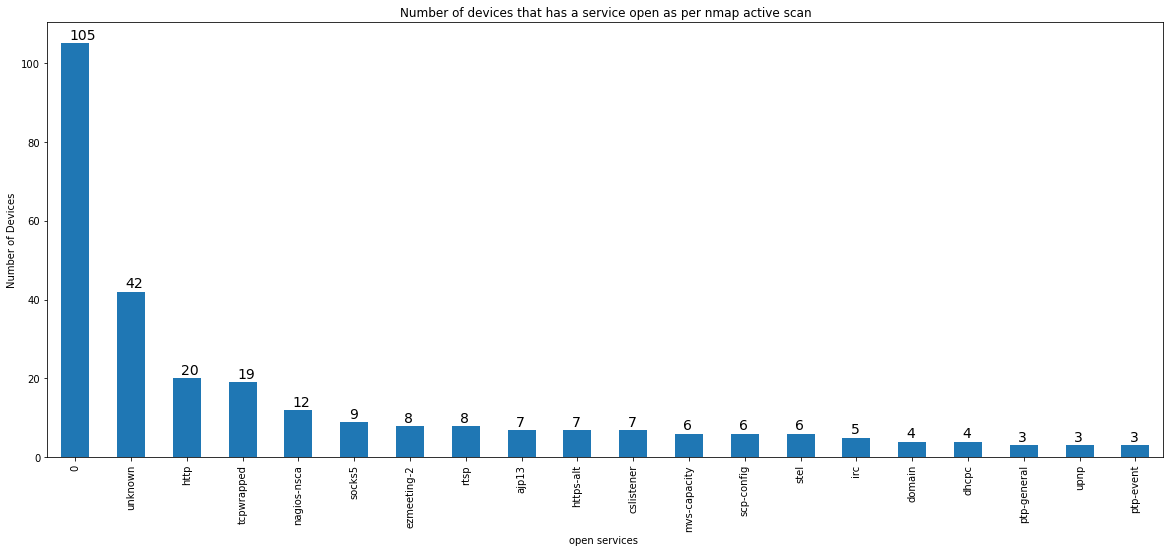

In [840]:
aa = aa.sort_values(by='device', ascending=False)


ax = aa.plot(kind='bar', rot=90, figsize=(20, 8), legend=False)
ax.set_xlabel('open services ')
ax.set_ylabel('Number of Devices')
ax.set_title('Number of devices that has a service open as per nmap active scan')

# Add the numbers on top of each bar
for i, v in enumerate(aa['device']):
    ax.text(i - 0.1, v + 1, str(v), color='black', fontsize=14)

plt.show()

In [700]:
df_nmap[df_nmap['protocol'] == 'tcp'].device.nunique()

54

----

## TCP + UDP

In [252]:
df_nmap_udp[['ip_addr', 'port_id']]

ip_addr port_id
0    192.168.10.189  61    
1    192.168.10.189  68    
2    192.168.10.189  129   
3    192.168.10.189  134   
4    192.168.10.189  186   
..              ...  ...   
127  192.168.10.134  856   
128  192.168.10.134  920   
129  192.168.10.134  955   
130  192.168.10.134  987   
131  192.168.10.148  443   

[132 rows x 2 columns]

In [315]:
df_nmap =  pd.concat([df_nmap_tcp, df_nmap_udp])

In [155]:
df_nmap.to_csv('nmap_tcp_udp_scans.csv')

In [453]:
df_nmap_udp['port_id'].nunique()

115

In [492]:
{'38817': 'tcpwrapped', '10005': 'stel', '56941': 'rtsp', '45587', '853', '10006/netapp-sync', '55443', '65225', '10010/rxapi', '8060/upnp', '53052/http', '43428', '8012', '38110/http', '49155', '49153/upnp', '60000/http', '9999/abyss'}

In [501]:
df_nmap[df_nmap['port_id'] == '9999']

scanner  \
24   nmap     
292  nmap     

                                                                                    args  \
24   nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_1 --exclude 192.168.10.243 nmap   
292  nmap -oX - -p 1-65535 -sS -sV -T4 --reason -iL part_2 --exclude 192.168.10.243 nmap   

     start_time            start_time_str version xmloutputversion verbose  \
24   1682247203  Sun Apr 23 10:53:23 2023  7.80    1.04             0        
292  1682262687  Sun Apr 23 15:11:27 2023  7.80    1.04             0        

    hosts_up hosts_down hosts_total         ip_addr           mac_addr  \
24   36       10         46          192.168.10.114  50:C7:BF:5A:2E:A0   
292  29       16         45          192.168.10.223  50:C7:BF:A0:F3:76   

                   vendor protocol port_id state   reason     service  \
24   Tp-link Technologies  tcp      9999    open  syn-ack  tcpwrapped   
292  Tp-link Technologies  tcp      9999    open  syn-ack  abyss        

    service_version       device  
24   unknown         tplink-plug  
292  unknown         tplink-bulb

In [379]:
grouped_df = df_nmap_udp.groupby('port_id')['device'].unique().reset_index(name='ports')
grouped_df['num_devices'] = grouped_df['ports'].apply(len)
grouped_df = grouped_df.sort_values('num_devices', ascending=False)
grouped_df

port_id                                    ports  num_devices
77   68      [roku-tv, fridge, arlo-q-cam, ikea-hub]  4          
51   53      [homepod-mini1, fridge, homepod-mini2]   3          
27   320     [roku-tv, homepod-mini1, homepod-mini2]  3          
26   319     [roku-tv, homepod-mini1, homepod-mini2]  3          
101  856     [nest-camera, pixel3b]                   2          
14   205     [wyze-cam, facebook-portal-mini]         2          
102  874     [wyze-cam, nest-camera]                  2          
52   546     [homepod-mini1, homepod-mini2]           2          
84   722     [fridge, pixel3b]                        2          
54   560     [wyze-cam, google-nest-mini2]            2          
29   343     [wyze-cam, facebook-portal-mini]         2          
1    1000    [ring-indoor-cam, facebook-portal-mini]  2          
75   676     [nest-camera]                            1          
81   712     [nest-camera]                            1          
80   708     [facebook-portal-mini]                   1          
82   714     [wyze-cam]                               1          
79   689     [roku-tv]                                1          
78   688     [facebook-portal-mini]                   1          
83   72      [facebook-portal-mini]                   1          
76   678     [pixel3b]                                1          
0    100     [fridge]                                 1          
74   652     [google-home-mini2]                      1          
73   642     [fridge]                                 1          
72   64      [pixel3b]                                1          
85   729     [arlo-q-cam]                             1          
70   63      [pixel3b]                                1          
69   622     [wyze-cam]                               1          
68   62      [google-home-mini2]                      1          
67   617     [nest-camera]                            1          
66   611     [t-philips-hub]                          1          
65   61      [roku-tv]                                1          
64   608     [facebook-portal-mini]                   1          
71   639     [roku-tv]                                1          
89   745     [ring-indoor-cam]                        1          
86   73      [yi-camera]                              1          
100  855     [google-nest-mini2]                      1          
113  987     [pixel3b]                                1          
112  955     [pixel3b]                                1          
111  933     [google-nest-mini2]                      1          
110  925     [google-home-mini]                       1          
109  920     [pixel3b]                                1          
108  918     [facebook-portal-mini]                   1          
107  907     [ring-indoor-cam]                        1          
106  906     [fridge]                                 1          
105  9       [ikettle]                                1          
104  898     [ring-indoor-cam]                        1          
103  881     [yi-camera]                              1          
99   850     [google-home-mini2]                      1          
87   735     [google-home-mini]                       1          
98   833     [google-home-mini]                       1          
97   824     [roku-tv]                                1          
96   823     [wyze-cam]                               1          
95   818     [pixel3b]                                1          
94   807     [nest-camera]                            1          
93   803     [nest-camera]                            1          
92   792     [wyze-cam]                               1          
91   774     [pixel3b]                                1          
90   75      [facebook-portal-mini]                   1          
62   600     [pixel3b]                                1          
88   737     [wyze-cam]                     

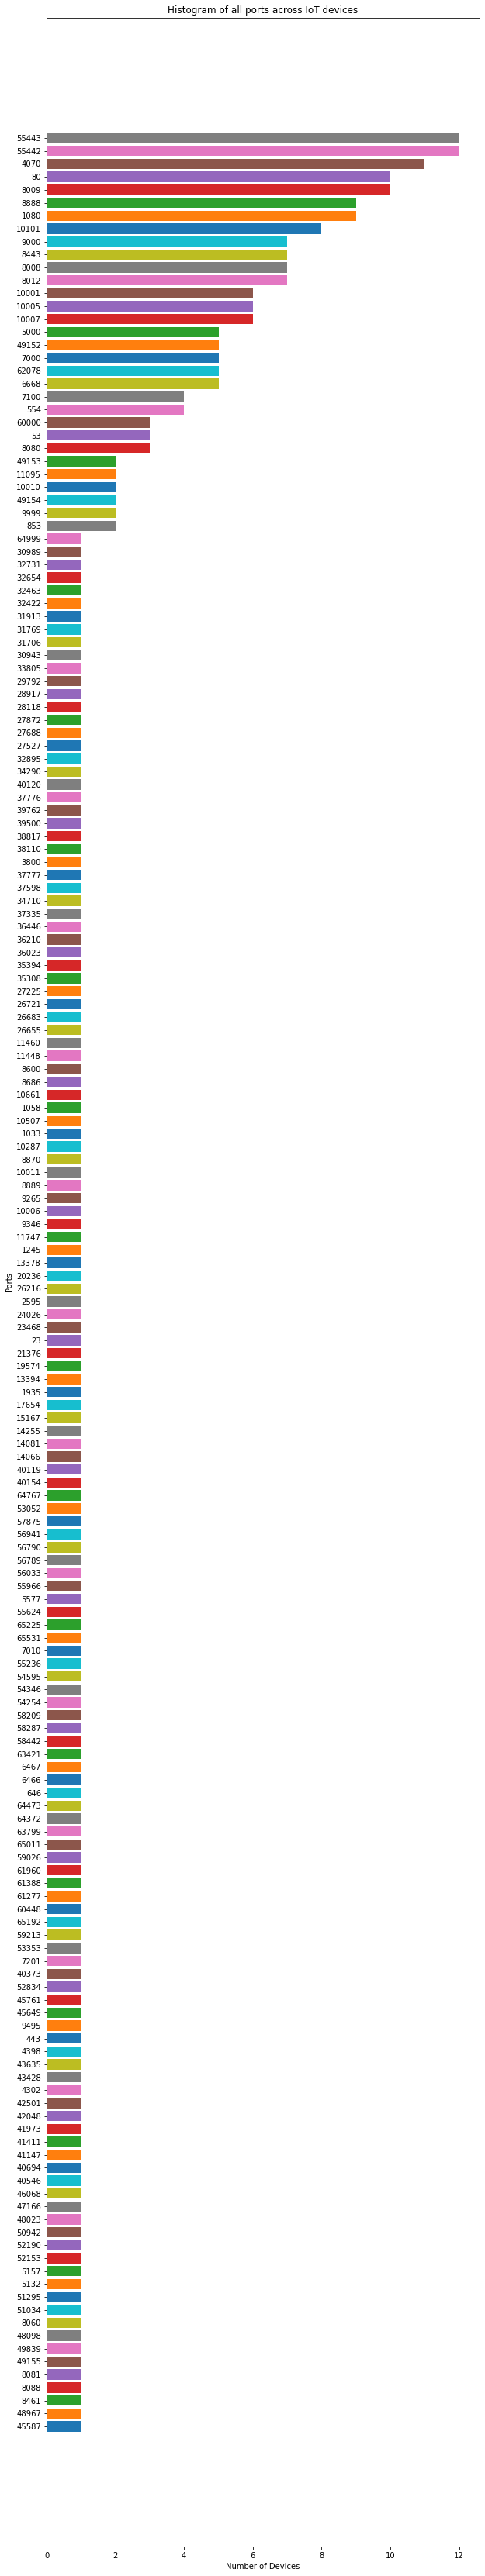

In [375]:
grouped_df = df_nmap_tcp.groupby('port_id')['ip_addr'].unique().reset_index(name='ports')
grouped_df['num_devices'] = grouped_df['ports'].apply(len)
grouped_df = grouped_df.sort_values('num_devices')

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(10, 60))

for index, row in grouped_df.iterrows():
    num_devices = row['num_devices']
    ports = row['port_id']
    ax.barh(ports, num_devices)

ax.set_ylabel('Ports')
ax.set_xlabel('Number of Devices')
ax.set_title('Histogram of all ports across IoT devices')
# ax.set_xticklabels(grouped_df['port_id'], rotation=90)

# ax.set_xticks(grouped_df['num_devices'])
# ax.set_xticklabels(grouped_df['ip_addr'])
plt.savefig("histogram all ports", transparent=True, bbox_inches='tight')
plt.show()

------

## IP Proto

In [217]:
ip_one = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-sO_-T4_--reason_-iL_part_2_-exclude_192.168.10.243_-v_2023-04-23_18-50-18.json'
ip_two = 'nmap_dataset/NEU/dict_dump_nmap_scan_nmap_-sO_-T4_--reason_-iL_part_1_-exclude_192.168.10.243_-v_2023-04-23_19-01-16.json'

In [218]:
with open(ip_one) as f:
    data_one = json.load(f)

with open(ip_two) as f:
    data_two = json.load(f)

In [219]:
df_one = json_to_dataframe(data_one)
df_two = json_to_dataframe(data_two)

df = pd.concat([df_one, df_two])
df.rename(columns = {'port_id':'protocol_num'}, inplace = True)


In [221]:
df.to_csv('nmap_ip_proto_scans.csv')

In [180]:
df_nmap[['device', 'port_id', 'protocol', 'service']]

device port_id protocol      service
0    echoplus           4070    tcp      nagios-nsca
1    echoplus           55442   tcp      nagios-nsca
2    echoplus           55443   tcp      unknown    
3    google-home-mini2  8008    tcp      http       
4    google-home-mini2  8009    tcp      ajp13      
..                 ...   ...    ...        ...      
127  pixel3b            856     udp      unknown    
128  pixel3b            920     udp      unknown    
129  pixel3b            955     udp      unknown    
130  pixel3b            987     udp      unknown    
131  echoshow5          443     udp      https      

[460 rows x 4 columns]

In [316]:
## Based on service

grouped_service = df_nmap.groupby('service')['device'].apply(list).reset_index()
grouped_service = grouped_service.drop(35)
grouped_service['device'] = grouped_service['device'].apply(lambda x: x[0] if len(x) == 1 else x)

grouped_service

service                       device
0    3com-tsmux    wyze-cam                   
1    9pfs          facebook-portal-mini       
2    abyss         tplink-bulb                
3    acas          google-home-mini2          
4    acmaint_dbd   pixel3b                    
..           ...       ...                    
113  vpps-via      nest-camera                
114  weave         [nest-camera, nest-hub-max]
115  worldfusion1  magichome-strip            
116  xns-auth      wyze-cam                   
117  zserv         ring-indoor-cam            

[117 rows x 2 columns]

In [778]:
df_nmap

scanner  \
0    nmap     
1    nmap     
2    nmap     
3    nmap     
4    nmap     
5    nmap     
6    nmap     
7    nmap     
8    nmap     
9    nmap     
10   nmap     
11   nmap     
12   nmap     
13   nmap     
14   nmap     
15   nmap     
16   nmap     
17   nmap     
18   nmap     
19   nmap     
20   nmap     
21   nmap     
22   nmap     
23   nmap     
24   nmap     
25   nmap     
26   nmap     
27   nmap     
28   nmap     
29   nmap     
30   nmap     
31   nmap     
32   nmap     
33   nmap     
34   nmap     
35   nmap     
36   nmap     
37   nmap     
38   nmap     
39   nmap     
40   nmap     
41   nmap     
42   nmap     
43   nmap     
44   nmap     
45   nmap     
46   nmap     
47   nmap     
48   nmap     
49   nmap     
50   nmap     
51   nmap     
52   nmap     
53   nmap     
54   nmap     
55   nmap     
56   nmap     
57   nmap     
58   nmap     
59   nmap     
60   nmap     
61   nmap     
62   nmap     
63   nmap     
64   nmap     
65   nmap     
66   nmap     
67   nmap     
68   nmap     
69   nmap     
70   nmap     
71   nmap     
72   nmap     
73   nmap     
74   nmap     
75   nmap     
76   nmap     
77   nmap     
78   nmap     
79   nmap     
80   nmap     
81   nmap     
82   nmap     
83   nmap     
84   nmap     
85   nmap     
86   nmap     
87   nmap     
88   nmap     
89   nmap     
90   nmap     
91   nmap     
92   nmap     
93   nmap     
94   nmap     
95   nmap     
96   nmap     
97   nmap     
98   nmap     
99   nmap     
100  nmap     
101  nmap     
102  nmap     
103  nmap     
104  nmap     
105  nmap     
106  nmap     
107  nmap     
108  nmap     
109  nmap     
110  nmap     
111  nmap     
112  nmap     
113  nmap     
114  nmap     
115  nmap     
116  nmap     
117  nmap     
118  nmap     
119  nmap     
120  nmap     
121  nmap     
122  nmap     
123  nmap     
124  nmap     
125  nmap     
126  nmap     
127  nmap     
128  nmap     
129  nmap     
130  nmap     
131  nmap     
132  nmap     
133  nmap     
134  nmap     
135  nmap     
136  nmap     
137  nmap     
138  nmap     
139  nmap     
140  nmap     
141  nmap     
142  nmap     
143  nmap     
144  nmap     
145  nmap     
146  nmap     
147  nmap     
148  nmap     
149  nmap     
150  nmap     
151  nmap     
152  nmap     
153  nmap     
154  nmap     
155  nmap     
156  nmap     
157  nmap     
158  nmap     
159  nmap     
160  nmap     
161  nmap     
162  nmap     
163  nmap     
164  nmap     
165  nmap     
166  nmap     
167  nmap     
168  nmap     
169  nmap     
170  nmap     
171  nmap     
172  nmap     
173  nmap     
174  nmap     
175  nmap     
176  nmap     
177  nmap     
178  nmap     
179  nmap     
180  nmap     
181  nmap     
182  nmap     
183  nmap     
184  nmap     
185  nmap     
186  nmap     
187  nmap     
188  nmap     
189  nmap     
190  nmap     
191  nmap     
192  nmap     
193  nmap     
194  nmap     
195  nmap     
196  nmap     
197  nmap     
198  nmap     
199  nmap     
200  nmap     
201  nmap     
202  nmap     
203  nmap     
204  nmap     
205  nmap     
206  nmap     
207  nmap     
208  nmap     
209  nmap     
210  nmap     
211  nmap     
212  nmap     
213  nmap     
214  nmap     
215  nmap     
216  nmap     
217  nmap     
218  nmap     
219  nmap     
220  nmap     
221  nmap     
222  nmap     
223  nmap     
224  nmap     
225  nmap     
226  nmap     
227  nmap     
228  nmap     
229  nmap     
230  nmap     
231  nmap     
232  nmap     
233  nmap     
234  nmap     
235  nmap     
236  nmap     
237  nmap     
238  nmap     
239  nmap     
240  nmap     
241  nmap     
242  nmap     
243  nmap     
244  nmap     
245  nmap     
246  nmap     
247  nmap     
248  nmap     
249  nmap     
250  nmap     
251  nmap     
252  nmap     
253  nmap     
254  nmap     
255  nmap     
256  nmap     
257  nmap     
258  nmap     
259  nmap     
260  nmap     
261  nmap     
262  nmap     
263  nmap     
264  nmap     
265  nmap     

In [351]:
grouped_df

device  \
0   ring-chime1                                                                                 
1   roku-tv                                                                                     
2   echoshow5                                                                                   
3   [echodot3a, echodot3c, echodot3d, echodot3uk, echodot4c, echodot5b, echoflex1, echoflex2]   
4   fridge                                                                                      
5   microseven-camera                                                                           
6   magichome-strip                                                                             
7   [echoplus, echospot]                                                                        
8   appletv-wifi                                                                                
9   sousvide                                                                                    
10  homepod                                                                                     
11  xiaomi-ricecooker                                                                           
12  t-wemo-plug                                                                                 
13  homepod-mini2                                                                               
14  homepod-mini1                                                                               
15  dlink-camera                                                                                
16  iphonexs                                                                                    
17  tivostream                                                                                  
18  [bulb1, gosund-bulb1, smartlife-bulb, thermopro-sensor, tuya-camera]                        
19  govee-led1                                                                                  
20  [meross-dooropener, tplink-tapo-plug]                                                       
21  meross-plug1                                                                                
22  t-philips-hub                                                                               
23  amcrest-cam-wired                                                                           
24  wansview-cam-wired                                                                          
25  meross-plug2                                                                                
26  lefun-cam-wired                                                                             
27  sengled-hub-spoofed                                                                         
28  nest-hub-max                                                                                
29  nest-hub                                                                                    
30  [google-home-mini, google-home-mini2, google-nest-mini1, google-nest-mini2]                 
31  echoshow8                                                                                   
32  firetv                                                                                      
33  nest-camera                                                                                 
34  facebook-portal-mini                                                                        
35  smartthings-hub                                                                             
36  [tplink-bulb, tplink-plug]                                                                  

                                                                                                                                                                   port_id  
0   [1033, 8461, 19574, 21376, 27225, 36210, 42501, 48023, 49839, 51295, 57875, 61388]                                                                                      
1   [1058, 7000, 8060, 36446, 52190, 58442, 61277]    

In [812]:
## Based on ports
grouped_ports = df_nmap.groupby(['device', 'protocol'])['port_id'].apply(list).reset_index()

grouped_ports['port_id'] = grouped_ports['port_id'].apply(tuple)

# Group by the 'open_ports' column and aggregate the devices into a list
grouped_df = grouped_ports.groupby('port_id')['device'].apply(list).reset_index()

# Convert the tuples in the 'open_ports' column back to lists
grouped_df['port_id'] = grouped_df['port_id'].apply(list)

# Remove the square brackets from the 'device' column
grouped_df['device'] = grouped_df['device'].apply(lambda x: x[0] if len(x) == 1 else x)

# # Remove the square brackets from the 'open_ports' column
# grouped_df['port_id'] = grouped_df['port_id'].apply(lambda x: ', '.join(map(str, x)))

pd.set_option('display.max_colwidth', -1)
grouped_df = grouped_df[['device', 'port_id']]

/tmp/ipykernel_489646/1325900726.py:18: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [805]:
grouped_ports = df_nmap.groupby(['service', 'protocol'])['device'].apply(list).reset_index()
device_percentage = grouped_ports

total_devices = 61  # Total number of devices

# Calculate the count of devices for each port
device_count = grouped_ports['device'].apply(lambda x: len(x))

# Calculate the percentage and add it as a new column
device_percentage['device_percentage'] = (device_count / total_devices) * 100

In [806]:
device_percentage = device_percentage.sort_values('device_percentage', ascending=False)

In [807]:
device_percentage[device_percentage['protocol'] == 'udp'] 

service protocol  \
110  unknown          udp       
24   dhcpc            udp       
82   ptp-general      udp       
81   ptp-event        udp       
30   domain           udp       
88   rmonitor         udp       
74   ock              udp       
25   dhcpv6-client    udp       
9    at-5             udp       
79   priv-dial        udp       
80   priv-print       udp       
83   pwdgen           udp       
113  via-ftp          udp       
78   pov-ray          udp       
86   realm-rusd       udp       
77   pawserv          udp       
76   odmr             udp       
75   ocserver         udp       
73   nqs              udp       
72   npmp-gui         udp       
71   novastorbakcup   udp       
70   nmap             udp       
68   ni-mail          udp       
91   sco-dtmgr        udp       
102  sur-meas         udp       
114  vnas             udp       
108  tpip             udp       
106  td-service       udp       
115  vpps-via         udp       
104  tcpnethaspsrv    udp       
103  tbrpf            udp       
118  xns-auth         udp       
100  stmf             udp       
98   sometimes-rpc2   udp       
95   sift-uft         udp       
66   netrjs-3         udp       
94   siam             udp       
93   sfs-config       udp       
67   netviewdm1       udp       
0    3com-tsmux       udp       
65   netrjs-2         udp       
34   firewall1-rdp    udp       
31   esro-emsdp       udp       
27   discard          udp       
26   digital-vrc      udp       
22   dasp             udp       
18   crs              udp       
17   covia            udp       
16   collaborator     udp       
14   bgp              udp       
13   avian            udp       
12   aurora-cmgr      udp       
11   audit            udp       
10   at-echo          udp       
7    ariel2           udp       
5    acr-nema         udp       
4    acmaint_dbd      udp       
3    acas             udp       
32   eyelink          udp       
35   fw1-or-bgmp      udp       
36   ggf-ncp          udp       
63   netconfsoapbeep  udp       
62   netbios-ns       udp       
1    9pfs             udp       
59   mylex-mapd       udp       
57   msdp             udp       
56   ms-rome          udp       
55   metagram         udp       
53   mailq            udp       
52   ljk-login        udp       
50   knet-cmp         udp       
49   kis              udp       
47   iris-xpcs        udp       
45   ipcserver        udp       
44   ingres-net       udp       
43   imap4-ssl        udp       
42   icad-el          udp       
40   https            udp       
37   hello-port       udp       
119  zserv            udp       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  device  \
110  [roku-tv, yi-camera, yi-camera, yi-camera, fridge, fridge, fridge, ring-indoor-cam, ring-indoor-cam, ring-indoor-cam, ring-indoor-cam, wyze-cam, wyze-cam, wyze-cam, wyze-cam, wyze-cam, nest-camera, nest-camera, nest-camera, nest-camera, google-nest-mini2, google-nest-mini2, google-nest-mini2, google-nest-mini2, smartthings-hub, facebook-portal-mini, facebook-portal-mini, facebook-portal-mini, facebook-portal-mini, google-home-mini, google-home-mini, google-home-mini, google-home-mini2, google-home-mini2, pixel3b, pixel3b, pixel3b, pixel3b, pixel3b, pixel3b]   
24   [roku-tv, fridge, arlo-q-cam, ikea-hub]                                                                                                                                                       

In [813]:
grouped_traffic_df = traffic_df.groupby('device')['port'].sum()
unused_ports_df = pd.DataFrame(columns=['device', 'unused_ports'])

grouped_traffic_df = traffic_df.groupby('device')['port'].sum()

# Create a new dataframe to store the result
unused_ports_df = pd.DataFrame(columns=['device', 'unused_ports'])

# Iterate through the rows of the nmap_df
for index, row in grouped_ports.iterrows():
    device = row['device']
    nmap_ports = set(row['port_id'])

    if device in grouped_traffic_df.index:
        # Get the traffic ports for the same device from grouped_traffic_df
        traffic_ports = set(grouped_traffic_df[device])
    else:
        # If the device is not in the traffic_df, consider all nmap_ports as unused
        traffic_ports = set()

    # Find the unused ports by comparing nmap_ports and traffic_ports
    unused_ports = nmap_ports - traffic_ports

    # Append the result to the unused_ports_df
    unused_ports_df = unused_ports_df.append({'device': device, 'unused_ports': list(unused_ports)}, ignore_index=True)
    
def map_ports_to_services(device, unused_ports):
    services = []
    for port in unused_ports:
        service = df_nmap[(df_nmap['device'] == device) & (df_nmap['port_id'] == port)]['service'].values
        if len(service) > 0:
            services.append(service[0])
        else:
            services.append('unknown')
    return services

def remove_duplicates(lst):
    return list(set(lst))

# Apply the function to the unused_ports_df
unused_ports_df['unused_services'] = unused_ports_df.apply(lambda row: map_ports_to_services(row['device'], row['unused_ports']), axis=1)
unused_ports_df['unused_services'] = unused_ports_df['unused_services'].apply(remove_duplicates)

unused_ports_df

device  \
0   amcrest-cam-wired      
1   appletv-wifi           
2   arlo-q-cam             
3   bulb1                  
4   dlink-camera           
5   echodot3a              
6   echodot3c              
7   echodot3d              
8   echodot3uk             
9   echodot4c              
10  echodot5b              
11  echoflex1              
12  echoflex2              
13  echoplus               
14  echoshow5              
15  echoshow5              
16  echoshow8              
17  echospot               
18  facebook-portal-mini   
19  facebook-portal-mini   
20  firetv                 
21  fridge                 
22  fridge                 
23  google-home-mini       
24  google-home-mini       
25  google-home-mini2      
26  google-home-mini2      
27  google-nest-mini1      
28  google-nest-mini2      
29  google-nest-mini2      
30  gosund-bulb1           
31  govee-led1             
32  homepod                
33  homepod-mini1          
34  homepod-mini1          
35  homepod-mini2          
36  homepod-mini2          
37  ikea-hub               
38  ikettle                
39  iphonexs               
40  lefun-cam-wired        
41  magichome-strip        
42  meross-dooropener      
43  meross-plug1           
44  meross-plug2           
45  microseven-camera      
46  nest-camera            
47  nest-camera            
48  nest-hub               
49  nest-hub-max           
50  pixel3b                
51  ring-chime1            
52  ring-indoor-cam        
53  roku-tv                
54  roku-tv                
55  sengled-hub-spoofed    
56  sengled-hub-spoofed    
57  smartlife-bulb         
58  smartthings-hub        
59  smartthings-hub        
60  sousvide               
61  t-philips-hub          
62  t-philips-hub          
63  t-wemo-plug            
64  thermopro-sensor       
65  tivostream             
66  tplink-bulb            
67  tplink-plug            
68  tplink-tapo-plug       
69  tuya-camera            
70  wansview-cam-wired     
71  wyze-cam               
72  xiaomi-ricecooker      
73  yi-camera              

                                                                                                                                                              unused_ports  \
0   [37776, 3800, 5000, 80, 37777, 554]                                                                                                                                      
1   [49152, 5000, 7100, 4302, 62078, 27527]                                                                                                                                  
2   [729, 68]                                                                                                                                                                
3   [6668]                                                                                                                                                                   
4   [43635, 8088, 8870, 41147, 31769, 1245, 32731, 554, 8080, 31913, 11747, 31706, 8081]                                                                                     
5   [4070, 55442, 8888, 1080]                                                                                                                                                
6   [4070, 55442, 8888, 1080]                                                                                                                                                
7   [4070, 55442, 8888, 1080]                                                                                                                                                
8   [4070, 55442, 8888, 1080]                                                                                                                                                
9   [4070, 55442, 8888, 1080]                                                                                                                                                
10 

In [814]:
test = df_nmap_tcp.groupby(['port_id', 'service'], as_index=False).agg({'device': list})
test = df_nmap_tcp.groupby(['port_id', 'service'], as_index=False).agg({'device': set})

test['num_devices'] = test['device'].apply(len)
test['perc_devices'] = test['device'].apply(lambda x: (len(x) / 61) * 100)

test = test.sort_values('num_devices', ascending=False)
test

port_id          service  \
122  55442   nagios-nsca       
123  55443   unknown           
77   4070    nagios-nsca       
161  80      http              
12   1080    socks5            
178  8888    tcpwrapped        
6    10101   ezmeeting-2       
172  8443    https-alt         
163  8009    ajp13             
162  8008    http              
180  9000    cslistener        
165  8012    unknown           
0    10001   scp-config        
3    10007   mvs-capacity      
1    10005   stel              
156  6668    irc               
157  7000    rtsp              
142  62078   tcpwrapped        
159  7100    rtsp              
103  5000    rtsp              
96   49152   unknown           
137  60000   http              
113  53      domain            
164  8009    http              
121  554     rtsp              
13   11095   weave             
100  49154   unknown           
174  853     domain            
4    10010   rxapi             
116  54254   rtsp              
117  54346   unknown           
118  54595   unknown           
119  55236   unknown           
120  554     http              
170  8081    blackice-icecap   
182  9346    ctechlicensing    
181  9265    unknown           
183  9495    unknown           
124  55624   unknown           
125  5577    unknown           
126  55966   tcpwrapped        
127  56033   unknown           
128  56789   unknown           
115  53353   unknown           
112  52834   rtsp              
114  53052   http              
130  56941   rtsp              
111  52190   unknown           
110  52153   unknown           
109  5157    mediat            
108  5132    unknown           
107  51295   unknown           
106  51034   unknown           
105  50942   unknown           
104  5000    upnp              
102  49839   unknown           
101  49155   unknown           
184  9999    abyss             
99   49153   upnp              
98   49153   unknown           
129  56790   unknown           
132  58209   rtsp              
131  57875   unknown           
176  8686    sun-as-jmxrmi     
152  65011   unknown           
153  65192   unknown           
154  65225   unknown           
155  65531   unknown           
177  8870    unknown           
158  7010    ups-onlinet       
160  7201    dlip              
150  64767   unknown           
175  8600    asterix           
173  8461    unknown           
171  8088    radan-http        
166  8060    upnp              
167  8080    http              
168  8080    http-proxy        
151  64999   unknown           
149  6467    unknown           
169  8080    soap              
140  61388   unknown           
133  58287   unknown           
134  58442   unknown           
135  59026   unknown           
136  59213   unknown           
138  60448   unknown           
139  61277   unknown           
141  61960   unknown           
148  6466    unknown           
179  8889    ddi-tcp-2         
97   49152   upnp              
144  63799   unknown           
145  64372   unknown           
146  64473   unknown           
147  646     ldp               
143  63421   unknown           
93   48023   unknown           
95   48967   unknown           
94   48098   unknown           
29   23      telnet            
30   23468   unknown           
31   24026   unknown           
32   2595    worldfusion1      
33   26216   unknown           
34   26655   unknown           
35   26683   unknown           
36   26721   unknown           
37   27225   unknown           
38   27527   unknown           
39   27688   unknown           
40   27872   unknown           
41   28118   unknown           
42   28917   unknown           
43   29792   unknown           
44   30943   unknown           
45   30989   unknown           
46   31706   unknown           
47   31769   unknown           
28   21376   unknown           
27   20236   unknown           
26   19574   unknown           
15   11460   unknown           
2    10006   netapp-sync       
5   

In [767]:
test = df_nmap_udp.groupby(['port_id', 'service'], as_index=False).agg({'device': list})
test = df_nmap_udp.groupby(['port_id', 'service'], as_index=False).agg({'device': set})

test['num_devices'] = test['device'].apply(len)
test['perc_devices'] = test['device'].apply(lambda x: (len(x) / 61) * 100)

test = test.sort_values('num_devices', ascending=False)
test

port_id          service                                   device  \
77   68      dhcpc            {ikea-hub, roku-tv, arlo-q-cam, fridge}   
51   53      domain           {homepod-mini1, homepod-mini2, fridge}    
27   320     ptp-general      {homepod-mini1, homepod-mini2, roku-tv}   
26   319     ptp-event        {homepod-mini1, homepod-mini2, roku-tv}   
101  856     unknown          {pixel3b, nest-camera}                    
14   205     at-5             {facebook-portal-mini, wyze-cam}          
102  874     unknown          {nest-camera, wyze-cam}                   
52   546     dhcpv6-client    {homepod-mini1, homepod-mini2}            
84   722     unknown          {pixel3b, fridge}                         
54   560     rmonitor         {google-nest-mini2, wyze-cam}             
29   343     unknown          {facebook-portal-mini, wyze-cam}          
1    1000    ock              {facebook-portal-mini, ring-indoor-cam}   
75   676     vpps-via         {nest-camera}                             
81   712     tbrpf            {nest-camera}                             
80   708     unknown          {facebook-portal-mini}                    
82   714     iris-xpcs        {wyze-cam}                                
79   689     nmap             {roku-tv}                                 
78   688     realm-rusd       {facebook-portal-mini}                    
83   72      netrjs-2         {facebook-portal-mini}                    
76   678     ggf-ncp          {pixel3b}                                 
0    100     unknown          {fridge}                                  
74   652     hello-port       {google-home-mini2}                       
73   642     esro-emsdp       {fridge}                                  
72   64      covia            {pixel3b}                                 
85   729     netviewdm1       {arlo-q-cam}                              
70   63      via-ftp          {pixel3b}                                 
69   622     collaborator     {wyze-cam}                                
68   62      acas             {google-home-mini2}                       
67   617     sco-dtmgr        {nest-camera}                             
66   611     npmp-gui         {t-philips-hub}                           
65   61      ni-mail          {roku-tv}                                 
64   608     sift-uft         {facebook-portal-mini}                    
71   639     msdp             {roku-tv}                                 
89   745     unknown          {ring-indoor-cam}                         
86   73      netrjs-3         {yi-camera}                               
100  855     unknown          {google-nest-mini2}                       
113  987     unknown          {pixel3b}                                 
112  955     unknown          {pixel3b}                                 
111  933     unknown          {google-nest-mini2}                       
110  925     unknown          {google-home-mini}                        
109  920     unknown          {pixel3b}                                 
108  918     unknown          {facebook-portal-mini}                    
107  907     unknown          {ring-indoor-cam}                         
106  906     unknown          {fridge}                                  
105  9       discard          {ikettle}                                 
104  898     unknown          {ring-indoor-cam}                         
103  881     unknown          {yi-camera}                               
99   850     unknown          {google-home-mini2}                       
87   735     unknown          {google-home-mini}                        
98   833     netconfsoapbeep  {google-home-mini}                        
97   824     unknown          {roku-tv}                                 
96   823     unknown          {wyze-cam}                                
95   818     unknown          {pixel3b}                                 
94   807     unknown          {nest-camera}                   

In [768]:
results = []

# Iterate over each row in the dataframe
for index, row in unused_ports_df.iterrows():
    device = row['device']
    ports = row['unused_ports']
    services = row['unused_services']

    # Iterate over each service and port in the current row
    for port, service in zip(ports, services):
        # Create a dictionary with the current port, service, and device
        result = {'port': port, 'service': service, 'device': device}
        
        # Append the dictionary to the results list
        results.append(result)

def find_perc(x):
    return (x / 61) * 100

# Create a new dataframe with the results
result_df = pd.DataFrame(results)
# result_df = result_df.groupby(['port', 'service'], as_index=False).agg({'device': list})
result_df = result_df.groupby(['service'], as_index=False).agg({'device': list})

result_df['num_devices'] = result_df['device'].apply(len)
result_df['perc_devices'] = result_df['device'].apply(lambda x: (len(x) / 61) * 100)

result_df = result_df.sort_values('num_devices', ascending=False)
result_df

service  \
103  unknown           
35   http              
99   tcpwrapped        
57   nagios-nsca       
92   socks5            
85   rtsp              
38   https-alt         
55   mvs-capacity      
43   irc               
87   scp-config        
17   cslistener        
27   domain            
78   ptp-general       
77   ptp-event         
7    at-5              
23   dhcpv6-client     
70   ock               
109  weave             
84   rmonitor          
22   dhcpc             
81   radan-http        
80   pwgpsi            
79   pwdgen            
0    3com-tsmux        
76   priv-print        
75   priv-dial         
74   pov-ray           
82   realm-rusd        
72   odmr              
71   ocserver          
69   nqs               
68   npmp-gui          
67   novastorbakcup    
66   nmap              
65   nim               
64   ni-mail           
73   pawserv           
88   sfs-config        
83   reverse-ssl       
100  td-service        
111  xns-auth          
110  worldfusion1      
108  vpps-via          
107  vnas              
106  via-ftp           
105  ups-onlinet       
104  upnp              
102  tpip              
101  telnet            
98   tcpnethaspsrv     
86   sco-dtmgr         
97   tbrpf             
96   sur-meas          
95   sun-as-jmxrmi     
94   stmf              
93   sometimes-rpc2    
91   soap              
90   sift-uft          
89   siam              
62   netrjs-3          
63   netviewdm1        
56   mylex-mapd        
61   netrjs-2          
14   collaborator      
28   esro-emsdp        
26   dlip              
25   discard           
24   digital-vrc       
21   ddi-tcp-2         
20   dasp              
19   d-data-control    
18   ctechlicensing    
16   crs               
15   covia             
13   blackice-icecap   
30   ezmeeting-2       
12   bgp               
11   avian             
10   aurora-cmgr       
9    audit             
8    at-echo           
6    asterix           
5    ariel2            
4    acr-nema          
3    acmaint_dbd       
2    acas              
29   eyelink           
31   firewall1-rdp     
60   netinfo           
47   knet-cmp          
59   netconfsoapbeep   
58   netbios-ns        
1    9pfs              
54   msdp              
53   ms-rome           
52   metagram          
51   mediat            
50   mailq             
49   ljk-login         
48   ldp               
46   kis               
32   fw1-or-bgmp       
45   isbconference2    
44   iris-xpcs         
42   ipcserver         
41   ingres-net        
40   imap4-ssl         
39   icad-el           
37   https             
36   http-proxy        
34   hello-port        
33   ggf-ncp           
112  zserv             

                                                                                                                                                                                                                                                                                                                                                                                                                  device  \
103  [amcrest-cam-wired, appletv-wifi, dlink-camera, facebook-portal-mini, fridge, google-home-mini, google-home-mini2, google-nest-mini2, govee-led1, homepod, homepod-mini1, homepod-mini2, magichome-strip, meross-plug1, meross-plug2, nest-camera, nest-hub-max, pixel3b, ring-chime1, ring-indoor-cam, roku-tv, smartthings-hub, sousvide, tivostream, wansview-cam-wired, wyze-cam, xiaomi-ricecooker, yi-camera]   
35   [amcrest-cam-wired, echoshow5, echoshow8, firetv, google-home-mini, google-home-mini2, google-nest-mini1, google-nest-mini2, lefun-cam-wired, meross-dooropener, meross-plug1, meross-plug2, microseven-camera, nest-hub-max, sengled-hub-spoofed, t-philips-hub, tplink-tapo-plug, wansview-cam-wired]                                                                                                               
99   [appletv-wifi, echodot3a, echodot3c

In [770]:
unused_ports_df

device  \
0   amcrest-cam-wired      
1   appletv-wifi           
2   arlo-q-cam             
3   bulb1                  
4   dlink-camera           
5   echodot3a              
6   echodot3c              
7   echodot3d              
8   echodot3uk             
9   echodot4c              
10  echodot5b              
11  echoflex1              
12  echoflex2              
13  echoplus               
14  echoshow5              
15  echoshow8              
16  echospot               
17  facebook-portal-mini   
18  firetv                 
19  fridge                 
20  google-home-mini       
21  google-home-mini2      
22  google-nest-mini1      
23  google-nest-mini2      
24  gosund-bulb1           
25  govee-led1             
26  homepod                
27  homepod-mini1          
28  homepod-mini2          
29  ikea-hub               
30  ikettle                
31  iphonexs               
32  lefun-cam-wired        
33  magichome-strip        
34  meross-dooropener      
35  meross-plug1           
36  meross-plug2           
37  microseven-camera      
38  nest-camera            
39  nest-hub               
40  nest-hub-max           
41  pixel3b                
42  ring-chime1            
43  ring-indoor-cam        
44  roku-tv                
45  sengled-hub-spoofed    
46  smartlife-bulb         
47  smartthings-hub        
48  sousvide               
49  t-philips-hub          
50  t-wemo-plug            
51  thermopro-sensor       
52  tivostream             
53  tplink-bulb            
54  tplink-plug            
55  tplink-tapo-plug       
56  tuya-camera            
57  wansview-cam-wired     
58  wyze-cam               
59  xiaomi-ricecooker      
60  yi-camera              

                                                                                                                                                              unused_ports  \
0   [37776, 3800, 5000, 80, 37777, 554]                                                                                                                                      
1   [49152, 5000, 7100, 4302, 62078, 27527]                                                                                                                                  
2   [729, 68]                                                                                                                                                                
3   [6668]                                                                                                                                                                   
4   [43635, 8088, 8870, 41147, 31769, 1245, 32731, 554, 8080, 31913, 11747, 31706, 8081]                                                                                     
5   [4070, 55442, 8888, 1080]                                                                                                                                                
6   [4070, 55442, 8888, 1080]                                                                                                                                                
7   [4070, 55442, 8888, 1080]                                                                                                                                                
8   [4070, 55442, 8888, 1080]                                                                                                                                                
9   [4070, 55442, 8888, 1080]                                                                                                                                                
10  [4070, 55442, 8888, 1080]                                                                                                                                                
11  [4070, 55442, 8888, 1080]                                                                                                                                                
12  [4070, 55442, 8

In [774]:
all_ports = []
for index, row in unused_ports_df.iterrows():
    all_ports.extend(row['unused_ports'])

all_services = []
for index, row in unused_ports_df.iterrows():
    all_services.extend(row['unused_services'])

all_non_used_ports = []
for index, row in grouped_ports.iterrows():
    all_non_used_ports.extend(row['port_id'])

unique_ports = set(all_ports)
unique_non_used_ports = set(all_non_used_ports)
unique_services = set(all_services)

diff = unique_non_used_ports - unique_ports
# Calculate the total number of unique ports
total_unique_ports = len(unique_ports)
total_unique_services = len(all_services)

print(diff)
print("Total number of unique unused ports:", total_unique_ports)
print("Total number of unique unused services:", total_unique_services)

print("percentage of unused ports compared to open ports ", (total_unique_ports / len(unique_non_used_ports)) * 100)

{'38817', '10005', '56941', '45587', '853', '10006', '55443', '65225', '10010', '8060', '53052', '43428', '8012', '38110', '49155', '49153', '60000', '9999'}
Total number of unique unused ports: 273
Total number of unique unused services: 232
percentage of unused ports compared to open ports  93.81443298969072


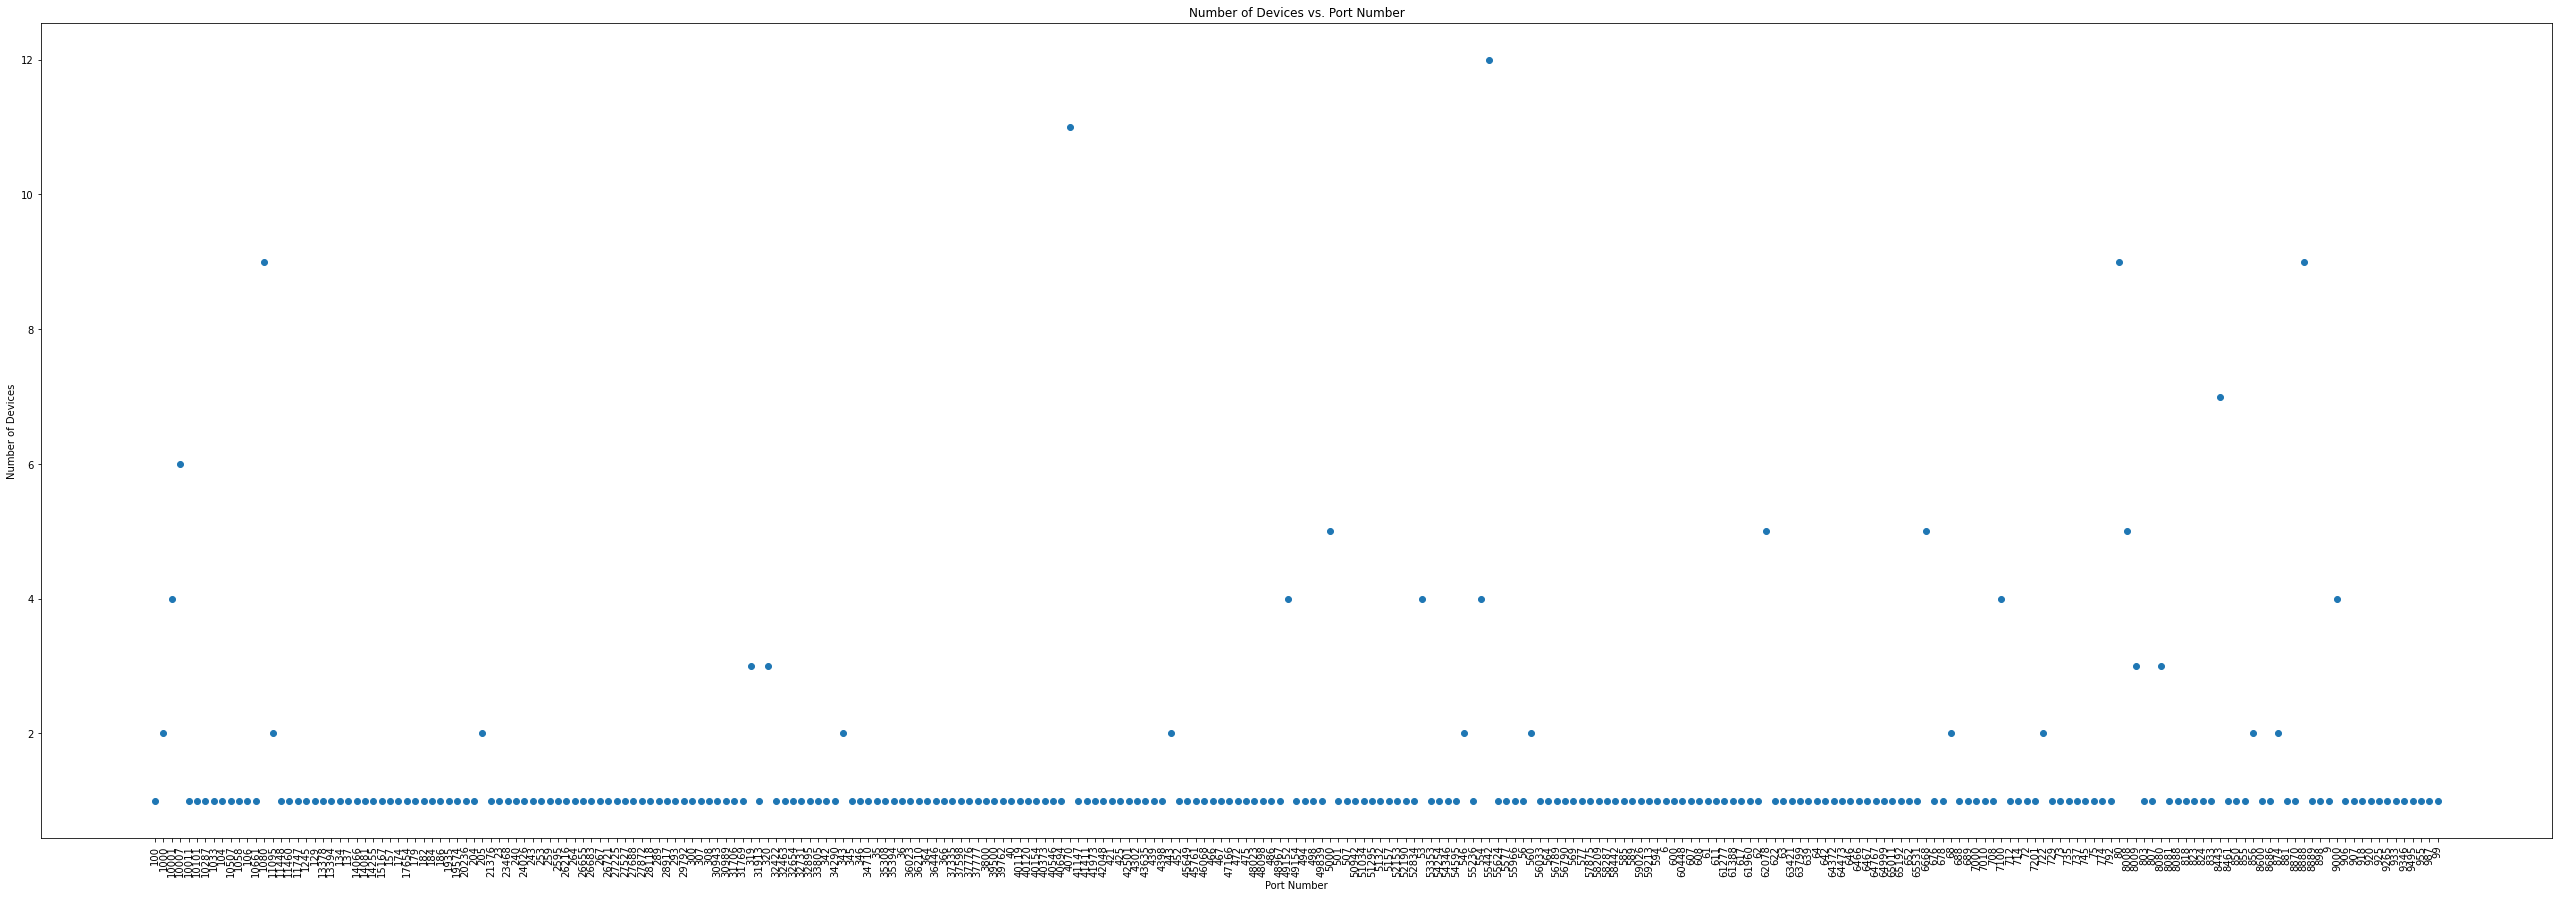

In [396]:
ports_data = []
for index, row in unused_ports_df.iterrows():
    device = row['device']
    for port in row['unused_ports']:
        ports_data.append({'device': device, 'port': port})

ports_df = pd.DataFrame(ports_data)

# Group by port number and count the occurrences
port_counts = ports_df.groupby('port')['device'].count().reset_index(name='device_count')
# port_counts = port_counts.sort_values('device_count')

# port_counts = ports_df.groupby('port')['device'].count().reset_index(name='device_count')

# Create the scatterplot
plt.figure(figsize=(45, 15))
plt.scatter(port_counts['port'], port_counts['device_count'])
plt.xlabel('Port Number')
plt.ylabel('Number of Devices')
plt.xticks(rotation=90)
plt.title('Number of Devices vs. Port Number')
# plt.grid(True)
plt.show()

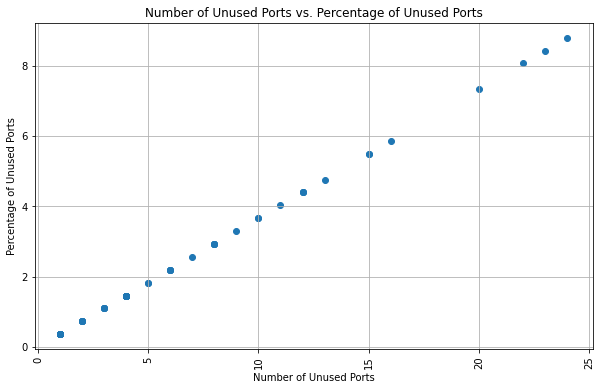

In [411]:
port_counts = ports_df.groupby('device')['port'].count().reset_index(name='device_count')

# Calculate the total number of unique unused ports
total_unused_ports = len(port_counts)

# Calculate the percentage of unused ports for each port

# 273 == Total number of unused unique ports
port_counts['percentage'] = (port_counts['device_count'] / 273) * 100

# Create the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(port_counts['device_count'], port_counts['percentage'])
plt.xlabel('Number of Unused Ports')
plt.ylabel('Percentage of Unused Ports')
plt.title('Number of Unused Ports vs. Percentage of Unused Ports')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

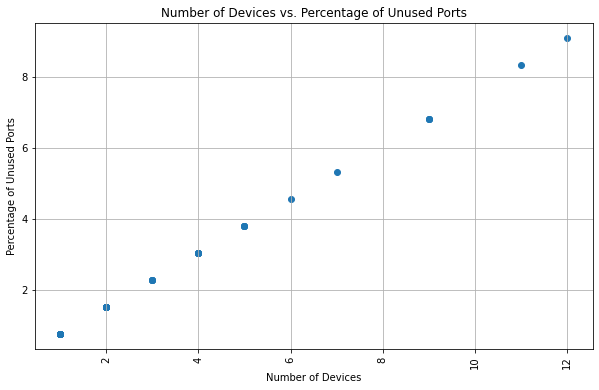

In [502]:
# Group by port number and count the occurrences
port_counts = ports_df.groupby('port')['device'].count().reset_index(name='device_count')

# Calculate the total number of devices
total_devices = len(df)

# Calculate the percentage of unused ports for each port
port_counts['percentage'] = (port_counts['device_count'] / total_devices) * 100

# Create the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(port_counts['device_count'], port_counts['percentage'])
plt.xlabel('Number of Devices')
plt.ylabel('Percentage of Unused Ports')
plt.title('Number of Devices vs. Percentage of Unused Ports')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
grouped_ports.loc[3, 'port_id']

['6668']

In [97]:
latex_table = grouped_df.to_latex(index=False)

In [167]:
grouped_ports

device  \
0   amcrest-cam-wired    
1   appletv-wifi         
2   arlo-q-cam           
3   bulb1                
4   dlink-camera         
..           ...         
56  tuya-camera          
57  wansview-cam-wired   
58  wyze-cam             
59  xiaomi-ricecooker    
60  yi-camera            

                                                                                                                                                                   port_id  
0   (80, 554, 3800, 5000, 37776, 37777, 49152)                                                                                                                              
1   (4302, 5000, 7000, 7100, 27527, 49152, 49153, 56941, 62078)                                                                                                             
2   (68, 729)                                                                                                                                                               
3   (6668,)                                                                                                                                                                 
4   (554, 1245, 8080, 8081, 8088, 8870, 11747, 31706, 31769, 31913, 32731, 41147, 43635)                                                                                    
..                                                                                   ...                                                                                    
56  (6668,)                                                                                                                                                                 
57  (80, 554, 65531)                                                                                                                                                        
58  (40, 56, 106, 182, 205, 267, 343, 472, 475, 560, 622, 714, 737, 792, 823, 874)                                                                                          
59  (5132, 9265, 14255, 15167, 20236, 26216, 26655, 28118, 28917, 30943, 32654, 33805, 37335, 40120, 40154, 40546, 40694, 41411, 45649, 46068, 51034, 54595, 63799, 64372)  
60  (73, 253, 289, 364, 452, 881)                                                                                                                                           

[61 rows x 2 columns]

In [23]:
grouped_traffic_df

device
amazon-plug                                                       [68]
amcrest-cam-wired                                   [49152, 39965, 68]
appletv-wifi         [55477, 56325, 55754, 55016, 55948, 55099, 550...
aqara-hub                                                   [68, 5353]
arlo-doorbell                                                     [68]
                                           ...                        
withings-sleep                                                    [68]
wiz-bulb                                                   [68, 58716]
xiaomi-ricecooker                                                 [68]
yeelight-bulb                                        [49155, 1982, 68]
yi-camera            [23983, 17033, 26784, 15141, 21068, 10298, 144...
Name: port, Length: 80, dtype: object

In [652]:
rm_long_tail

device        service
0    amcrest-cam-wired     unknown      
1    appletv-wifi          unknown      
2    dlink-camera          unknown      
3    facebook-portal-mini  unknown      
4    fridge                unknown      
5    google-home-mini      unknown      
6    google-home-mini2     unknown      
7    google-nest-mini2     unknown      
8    govee-led1            unknown      
9    homepod               unknown      
10   homepod-mini1         unknown      
11   homepod-mini2         unknown      
12   magichome-strip       unknown      
13   meross-plug1          unknown      
14   meross-plug2          unknown      
15   nest-camera           unknown      
16   nest-hub-max          unknown      
17   pixel3b               unknown      
18   ring-chime1           unknown      
19   ring-indoor-cam       unknown      
20   roku-tv               unknown      
21   smartthings-hub       unknown      
22   sousvide              unknown      
23   tivostream            unknown      
24   wansview-cam-wired    unknown      
25   wyze-cam              unknown      
26   xiaomi-ricecooker     unknown      
27   yi-camera             unknown      
28   amcrest-cam-wired     http         
29   echoshow5             http         
30   echoshow8             http         
31   firetv                http         
32   google-home-mini      http         
33   google-home-mini2     http         
34   google-nest-mini1     http         
35   google-nest-mini2     http         
36   lefun-cam-wired       http         
37   meross-dooropener     http         
38   meross-plug1          http         
39   meross-plug2          http         
40   microseven-camera     http         
41   nest-hub-max          http         
42   sengled-hub-spoofed   http         
43   t-philips-hub         http         
44   tplink-tapo-plug      http         
45   wansview-cam-wired    http         
46   appletv-wifi          tcpwrapped   
47   echodot3a             tcpwrapped   
48   echodot3c             tcpwrapped   
49   echodot3d             tcpwrapped   
50   echodot3uk            tcpwrapped   
51   echodot4c             tcpwrapped   
52   echodot5b             tcpwrapped   
53   echoflex1             tcpwrapped   
54   echoflex2             tcpwrapped   
55   echoshow5             tcpwrapped   
56   firetv                tcpwrapped   
57   homepod               tcpwrapped   
58   homepod-mini1         tcpwrapped   
59   homepod-mini2         tcpwrapped   
60   iphonexs              tcpwrapped   
61   microseven-camera     tcpwrapped   
62   echodot3a             nagios-nsca  
63   echodot3c             nagios-nsca  
64   echodot3d             nagios-nsca  
65   echodot3uk            nagios-nsca  
66   echodot4c             nagios-nsca  
67   echodot5b             nagios-nsca  
68   echoflex1             nagios-nsca  
69   echoflex2             nagios-nsca  
70   echoplus              nagios-nsca  
71   echoshow5             nagios-nsca  
72   echoshow8             nagios-nsca  
73   echospot              nagios-nsca  
74   echodot3a             socks5       
75   echodot3c             socks5       
76   echodot3d             socks5       
77   echodot3uk            socks5       
78   echodot4c             socks5       
79   echodot5b             socks5       
80   echoflex1             socks5       
81   echoflex2             socks5       
82   echoshow5             socks5       
83   amcrest-cam-wired     rtsp         
84   appletv-wifi          rtsp         
85   dlink-camera          rtsp         
86   homepod               rtsp         
87   homepod-mini1         rtsp         
88   homepod-mini2         rtsp         
89   microseven-camera     rtsp         
90   roku-tv               rtsp         
91   google-home-mini      https-alt    
92   google-home-mini2     https-alt    
93   google-nest-mini1     https-alt    
94   google-nest-mini2     https-alt    
95   nest-hub              https-alt    
96   nest-hub-max          https-alt    
9

In [688]:
result_df

service  \
103  unknown          
35   http             
99   tcpwrapped       
57   nagios-nsca      
92   socks5           
85   rtsp             
38   https-alt        
55   mvs-capacity     
43   irc              
87   scp-config       
17   cslistener       
27   domain           
78   ptp-general      
77   ptp-event        
7    at-5             
23   dhcpv6-client    
70   ock              
109  weave            
84   rmonitor         
22   dhcpc            
81   Other services   
80   Other services   
79   Other services   
0    Other services   
76   Other services   
75   Other services   
74   Other services   
82   Other services   
72   Other services   
71   Other services   
69   Other services   
68   Other services   
67   Other services   
66   Other services   
65   Other services   
64   Other services   
73   Other services   
88   Other services   
83   Other services   
100  Other services   
111  Other services   
110  Other services   
108  Other services   
107  Other services   
106  Other services   
105  Other services   
104  Other services   
102  Other services   
101  Other services   
98   Other services   
86   Other services   
97   Other services   
96   Other services   
95   Other services   
94   Other services   
93   Other services   
91   Other services   
90   Other services   
89   Other services   
62   Other services   
63   Other services   
56   Other services   
61   Other services   
14   Other services   
28   Other services   
26   Other services   
25   Other services   
24   Other services   
21   Other services   
20   Other services   
19   Other services   
18   Other services   
16   Other services   
15   Other services   
13   Other services   
30   Other services   
12   Other services   
11   Other services   
10   Other services   
9    Other services   
8    Other services   
6    Other services   
5    Other services   
4    Other services   
3    Other services   
2    Other services   
29   Other services   
31   Other services   
60   Other services   
47   Other services   
59   Other services   
58   Other services   
1    Other services   
54   Other services   
53   Other services   
52   Other services   
51   Other services   
50   Other services   
49   Other services   
48   Other services   
46   Other services   
32   Other services   
45   Other services   
44   Other services   
42   Other services   
41   Other services   
40   Other services   
39   Other services   
37   Other services   
36   Other services   
34   Other services   
33   Other services   
112  Other services   

                                                                                                                                                                                                                                                                                                                                                                                                                  device  \
103  [amcrest-cam-wired, appletv-wifi, dlink-camera, facebook-portal-mini, fridge, google-home-mini, google-home-mini2, google-nest-mini2, govee-led1, homepod, homepod-mini1, homepod-mini2, magichome-strip, meross-plug1, meross-plug2, nest-camera, nest-hub-max, pixel3b, ring-chime1, ring-indoor-cam, roku-tv, smartthings-hub, sousvide, tivostream, wansview-cam-wired, wyze-cam, xiaomi-ricecooker, yi-camera]   
35   [amcrest-cam-wired, echoshow5, echoshow8, firetv, google-home-mini, google-home-mini2, google-nest-mini1, google-nest-mini2, lefun-cam-wired, meross-dooropener, meross-plug1, meross-plug2, microseven-camera, nest-hub-max, sengled-hub-spoofed, t-philips-hub, tplink-tapo-plug, wansview-cam-wired]                                                                                                               
99   [appletv-wifi, echodot3a, echodot3c, echodot3d, echodot3uk, echodot4c, echodot5b, echoflex1, echoflex2, echoshow5, firetv, homepod, homepod-mini1, h

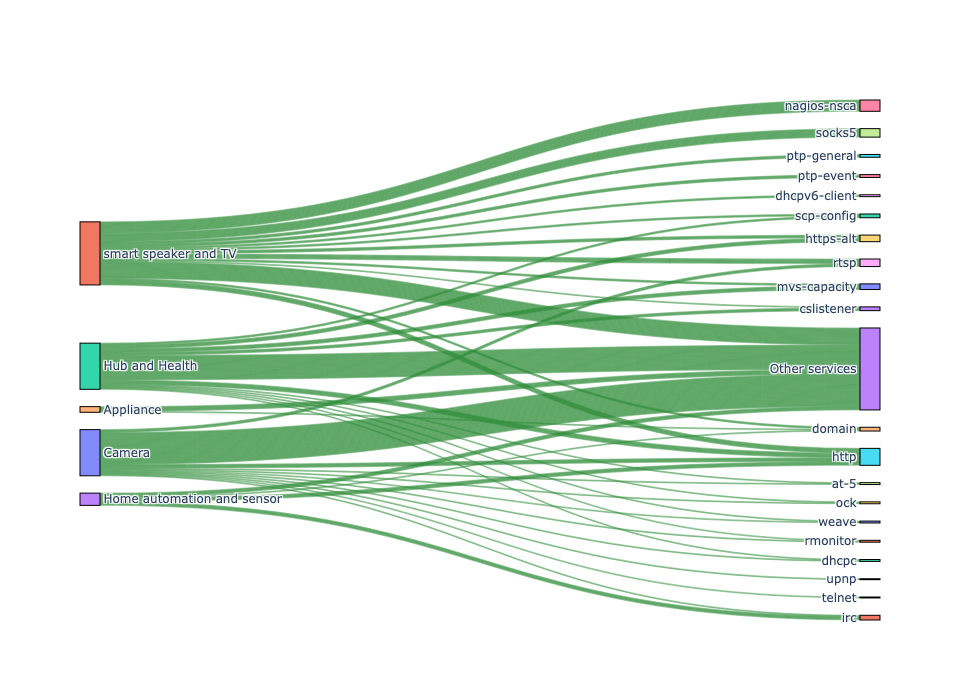

In [759]:
result_df.loc[result_df['perc_devices'] <= 3.2, 'service'] = "Other services"
# rm_long_tail = rm_long_tail[['device', 'service']].explode('device')
result_df = result_df.explode('device')
unused_ports_df = result_df

unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'iphonexs'].index)
unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'pixel3b'].index)

unused_ports_df['device'] = unused_ports_df['device'].replace('homepod', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('homepod-mini1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('homepod-mini2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-home-mini2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-nest-mini1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3uk', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3c', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3d', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('tivostream', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('appletv-wired', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('appletv-wifi', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echospot', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoplus', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot5b', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot4c', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3a', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoshow5', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoshow8', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('firetv', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('roku-tv', 'smart speaker and TV')

unused_ports_df['device'] = unused_ports_df['device'].replace('ring-chime1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('magichome-strip', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('govee-led1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-plug1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-dooropener', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-plug2', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('t-wemo-plug', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('bulb1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('gosund-bulb1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('smartlife-bulb', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('thermopro-sensor', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('tplink-tapo-plug', 'Home automation and sensor')


unused_ports_df['device'] = unused_ports_df['device'].replace('xiaomi-ricecooker', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('sousvide', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikettle', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('fridge', 'Appliance')

unused_ports_df['device'] = unused_ports_df['device'].replace('dlink-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('tuya-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('ring-indoor-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('arlo-q-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('lefun-cam-wired', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('yi-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('wyze-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('microseven-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('amcrest-cam-wired', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('wansview-cam-wired', 'Camera')


unused_ports_df['device'] = unused_ports_df['device'].replace('smartthings-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('t-philips-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('sengled-hub-spoofed', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-hub-max', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-nest-mini2', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-home-mini', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('facebook-portal-mini', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')

new_row = [{'device': 'Camera', 'service': 'upnp'},
           {'device': 'Camera', 'service': 'telnet'}]
unused_ports_df = unused_ports_df.append(new_row, ignore_index=True)

# unused_ports_df.to_csv("unused_ports_df.csv")

labels_mapping = {label: idx for idx, label in enumerate(pd.concat([unused_ports_df['device'], unused_ports_df['service']]).unique())}

# Create the labels list
labels = list(labels_mapping.keys())

# Create the sources and targets lists
sources = unused_ports_df['device'].map(labels_mapping).tolist()
targets = unused_ports_df['service'].map(labels_mapping).tolist()

# Create the values list (assuming a value of 1 for each connection)
values = [1] * len(sources)

node_colors = [
    'rgba(255, 0, 0, 0.5)',   # Light red
    'rgba(0, 0, 255, 0.5)',   # Light blue
    'rgba(0, 128, 0, 0.5)',   # Light green
    'rgba(255, 165, 0, 0.5)', # Light orange
    'rgba(128, 0, 128, 0.5)'  # Light purple
]

# Create a list of colors for the links that corresponds to the source node's color
link_color = [node_colors[src] for src in sources]

# x_positions = [0, 0, 0, 1, 1]
# y_positions = [0, 0.5, 1, 0.33, 0.66]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=20, thickness=20, line=dict(color='black', width=1), label=labels),
    link=dict(source=sources, target=targets, value=values, color='rgba(50, 142, 60, 0.4)')
)])
fig.update_layout(font_size=12, height=700, width=600)
# fig.write_image("Devices and unused Services.pdf")
fig.show()

In [678]:
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'homepod-mini2'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'echoflex2'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'google-home-mini2'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'google-nest-mini1'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'iphonexs'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'echodot3uk'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'echodot3c'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'echodot3d'].index)
# unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'bulb1'].index)
# unused_ports_df = rm_long_tail

unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'iphonexs'].index)
unused_ports_df = unused_ports_df.drop(unused_ports_df[unused_ports_df['device'] == 'pixel3b'].index)

unused_ports_df['device'] = unused_ports_df['device'].replace('homepod', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('homepod-mini1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('homepod-mini2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-home-mini2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-nest-mini1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3uk', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3c', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3d', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('tivostream', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('appletv-wired', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('appletv-wifi', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echospot', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoplus', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex2', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoflex1', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot5b', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot4c', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echodot3a', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoshow5', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('echoshow8', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('firetv', 'smart speaker and TV')
unused_ports_df['device'] = unused_ports_df['device'].replace('roku-tv', 'smart speaker and TV')

unused_ports_df['device'] = unused_ports_df['device'].replace('ring-chime1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('magichome-strip', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('govee-led1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-plug1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-dooropener', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('meross-plug2', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('t-wemo-plug', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('bulb1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('gosund-bulb1', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('smartlife-bulb', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('thermopro-sensor', 'Home automation and sensor')
unused_ports_df['device'] = unused_ports_df['device'].replace('tplink-tapo-plug', 'Home automation and sensor')


unused_ports_df['device'] = unused_ports_df['device'].replace('xiaomi-ricecooker', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('sousvide', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikettle', 'Appliance')
unused_ports_df['device'] = unused_ports_df['device'].replace('fridge', 'Appliance')

unused_ports_df['device'] = unused_ports_df['device'].replace('dlink-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('tuya-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('ring-indoor-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('arlo-q-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('lefun-cam-wired', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('yi-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('wyze-cam', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('microseven-camera', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('amcrest-cam-wired', 'Camera')
unused_ports_df['device'] = unused_ports_df['device'].replace('wansview-cam-wired', 'Camera')


unused_ports_df['device'] = unused_ports_df['device'].replace('smartthings-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('t-philips-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('sengled-hub-spoofed', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('nest-hub-max', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-nest-mini2', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('google-home-mini', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('facebook-portal-mini', 'Hub and Health')
unused_ports_df['device'] = unused_ports_df['device'].replace('ikea-hub', 'Hub and Health')



# Prepare data for Sankey diagram
labels = []
sources = []
targets = []
values = []

for index, row in unused_ports_df.iterrows():
    device = row['device']
    services = row['unused_services']
    
    # Add device label if not already in the labels list
    if device not in labels:
        labels.append(device)
    
    for service in services:
        # Add service label if not already in the labels list
        if service not in labels:
            labels.append(service)
        
        source_index = labels.index(device)
        target_index = labels.index(service)

        sources.append(source_index)
        targets.append(target_index)
        values.append(1)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color='black', width=1), label=labels),
    link=dict(source=sources, target=targets, value=values, color='rgba(56, 142, 60, 0.5)')
)])

fig.update_layout(title_text='Devices and unused Services', font_size=10, height=1500)
fig.show()

KeyError: 'unused_services'

In [634]:
unused_ports_df

device        service
35   Camera                      http         
35   smart speaker and TV        http         
35   smart speaker and TV        http         
35   smart speaker and TV        http         
35   Hub and Health              http         
35   smart speaker and TV        http         
35   smart speaker and TV        http         
35   Hub and Health              http         
35   Camera                      http         
35   Home automation and sensor  http         
35   Home automation and sensor  http         
35   Home automation and sensor  http         
35   Camera                      http         
35   Hub and Health              http         
35   Hub and Health              http         
35   Hub and Health              http         
35   Home automation and sensor  http         
35   Camera                      http         
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
57   smart speaker and TV        nagios-nsca  
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
92   smart speaker and TV        socks5       
85   Camera                      rtsp         
85   smart speaker and TV        rtsp         
85   Camera                      rtsp         
85   smart speaker and TV        rtsp         
85   smart speaker and TV        rtsp         
85   smart speaker and TV        rtsp         
85   Camera                      rtsp         
85   smart speaker and TV        rtsp         
38   Hub and Health              https-alt    
38   smart speaker and TV        https-alt    
38   smart speaker and TV        https-alt    
38   Hub and Health              https-alt    
38   Hub and Health              https-alt    
38   Hub and Health              https-alt    
38   smart speaker and TV        https-alt    
55   Hub and Health              mvs-capacity 
55   smart speaker and TV        mvs-capacity 
55   smart speaker and TV        mvs-capacity 
55   Hub and Health              mvs-capacity 
55   Hub and Health              mvs-capacity 
55   Hub and Health              mvs-capacity 
43   Home automation and sensor  irc          
43   Home automation and sensor  irc          
43   Home automation and sensor  irc          
43   Home automation and sensor  irc          
43   Camera                      irc          
87   Hub and Health              scp-config   
87   smart speaker and TV        scp-config   
87   smart speaker and TV        scp-config   
87   Hub and Health              scp-config   
17   smart speaker and TV        cslistener   
17   Hub and Health              cslistener   
17   Hub and Health              cslistener   
17   Hub and Health              cslistener   
27   Appliance                   domain       
27   smart speaker and TV        domain       
27   smart speaker and TV        domain       
27   Home automation and sensor  domain       
78   smart speaker and TV        ptp-general  
78   smart speaker and TV        ptp-general  
78   smart speaker and TV        ptp-general  
77   smart speaker and TV        ptp-event    
77   smart speaker and TV        ptp-event    
77   smart speaker and TV        ptp-event    
7    Hub and Health              at-5         
7    Camera                   

In [191]:
unused_ports_df['unused_ports'] = unused_ports_df['unused_ports'].apply(tuple)
# unused_ports_df['unused_services'] = unused_ports_df['unused_services'].apply(tuple)

# Group by the 'open_ports' column and aggregate the devices into a list
grouped_df = unused_ports_df.groupby('unused_ports')['device'].apply(list).reset_index()
# grouped_df = unused_ports_df.groupby('unused_services')['device'].apply(list).reset_index()

# Convert the tuples in the 'open_ports' column back to lists
grouped_df['unused_ports'] = grouped_df['unused_ports'].apply(list)
# grouped_df['unused_services'] = grouped_df['unused_services'].apply(list)


In [192]:
pd.set_option('display.max_colwidth', -1)
grouped_df = grouped_df[['device', 'unused_ports']]
grouped_df['device'] = grouped_df['device'].apply(lambda x: x[0] if len(x) == 1 else x)

# # Remove the square brackets from the 'open_ports' column
# grouped_df['unused_ports'] = grouped_df['unused_ports'].apply(lambda x: ', '.join(map(str, x)))

/tmp/ipykernel_489646/234933323.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [193]:
grouped_df = grouped_df.drop(0)

In [194]:
grouped_df

device  \
1   nest-camera                                                                                 
2   fridge                                                                                      
3   microseven-camera                                                                           
4   magichome-strip                                                                             
5   xiaomi-ricecooker                                                                           
6   wyze-cam                                                                                    
7   govee-led1                                                                                  
8   ring-indoor-cam                                                                             
9   meross-plug2                                                                                
10  roku-tv                                                                                     
11  amcrest-cam-wired                                                                           
12  smartthings-hub                                                                             
13  echoshow5                                                                                   
14  [echoplus, echospot]                                                                        
15  [echodot3a, echodot3c, echodot3d, echodot3uk, echodot4c, echodot5b, echoflex1, echoflex2]   
16  dlink-camera                                                                                
17  ring-chime1                                                                                 
18  sousvide                                                                                    
19  appletv-wifi                                                                                
20  homepod                                                                                     
21  homepod-mini1                                                                               
22  homepod-mini2                                                                               
23  facebook-portal-mini                                                                        
24  sengled-hub-spoofed                                                                         
25  t-wemo-plug                                                                                 
26  echoshow8                                                                                   
27  meross-plug1                                                                                
28  t-philips-hub                                                                               
29  pixel3b                                                                                     
30  iphonexs                                                                                    
31  [bulb1, gosund-bulb1, smartlife-bulb, thermopro-sensor, tuya-camera]                        
32  ikea-hub                                                                                    
33  lefun-cam-wired                                                                             
34  arlo-q-cam                                                                                  
35  yi-camera                                                                                   
36  [meross-dooropener, tplink-tapo-plug]                                                       
37  wansview-cam-wired                                                                          
38  firetv                                                                                      
39  google-home-mini                                                                            
40  google-nest-mini1                                                                           
41  nest-hub                                                                                    
42  tivostrea

In [175]:
print(grouped_df.to_latex(index=False))

\begin{tabular}{ll}
\toprule
                                                                                   device &                                                                                                                                                           unused\_ports \\
\midrule
nest-camera & [14066, 807, 421, 184, 874, 856, 11095, 712, 157, 466, 607, 803, 53353, 676, 617] \\
fridge & [17654, 37598, 100, 642, 906, 35394, 722, 53] \\
microseven-camera & [23, 554, 8080, 1935, 80] \\
magichome-strip & [2595, 29792, 36023, 32422, 10287, 64767, 64999, 14081, 32463, 50942, 52153, 26683, 42048, 34710, 5577, 59026, 56033, 24026, 10507, 60448, 32895, 34290] \\
xiaomi-ricecooker & [26216, 40120, 14255, 54595, 5132, 40546, 46068, 40154, 30943, 26655, 28118, 45649, 41411, 37335, 28917, 40694, 20236, 64372, 33805, 32654, 15167, 63799, 9265, 51034] \\
wyze-cam & [267, 560, 343, 40, 475, 205, 182, 737, 823, 874, 472, 106, 622, 792, 714, 56] \\
govee-led1 & [27688, 61960, 47166, 2

In [49]:
grouped_df

device  \
0   [tplink-bulb, tplink-plug]                                                                  
1   nest-camera                                                                                 
2   microseven-camera                                                                           
3   magichome-strip                                                                             
4   xiaomi-ricecooker                                                                           
5   govee-led1                                                                                  
6   meross-plug2                                                                                
7   fridge                                                                                      
8   amcrest-cam-wired                                                                           
9   smartthings-hub                                                                             
10  echoshow5                                                                                   
11  [echoplus, echospot]                                                                        
12  [echodot3a, echodot3c, echodot3d, echodot3uk, echodot4c, echodot5b, echoflex1, echoflex2]   
13  dlink-camera                                                                                
14  t-philips-hub                                                                               
15  ring-chime1                                                                                 
16  sousvide                                                                                    
17  appletv-wifi                                                                                
18  homepod                                                                                     
19  homepod-mini1                                                                               
20  homepod-mini2                                                                               
21  t-wemo-plug                                                                                 
22  echoshow8                                                                                   
23  facebook-portal-mini                                                                        
24  meross-plug1                                                                                
25  iphonexs                                                                                    
26  [bulb1, gosund-bulb1, smartlife-bulb, thermopro-sensor, tuya-camera]                        
27  roku-tv                                                                                     
28  lefun-cam-wired                                                                             
29  [meross-dooropener, tplink-tapo-plug]                                                       
30  wansview-cam-wired                                                                          
31  firetv                                                                                      
32  [google-home-mini2, google-nest-mini2]                                                      
33  [google-home-mini, google-nest-mini1]                                                       
34  nest-hub                                                                                    
35  tivostream                                                                                  
36  nest-hub-max                                                                                
37  sengled-hub-spoofed                                                                         

                                                                                                                                                              unused_ports  
0   []                                                                                                                            

In [50]:
# Initialize an empty set to store unique unused ports
unique_unused_ports = set()

# Iterate through the rows of the unused_ports_df
for index, row in unused_ports_df.iterrows():
    # Add the ports from each row to the unique_unused_ports set
    unique_unused_ports.update(row['unused_ports'])

# Count the total number of unique unused TCP ports
total_unique_unused_ports = len(unique_unused_ports)

print("Total number of unique unused TCP ports:", total_unique_unused_ports)


Total number of unique unused TCP ports: 160


--------

In [669]:
import plotly.graph_objects as go
import plotly

In [224]:
source = df_nmap['service'].unique().tolist()
target = df_nmap['device'].unique().tolist()
labels = source + target

In [225]:
connections = df_nmap.groupby(['service', 'device']).size().reset_index(name='value')

In [226]:
connections


service                device  value
0    3com-tsmux    wyze-cam              1    
1    9pfs          facebook-portal-mini  1    
2    abyss         tplink-bulb           1    
3    acas          google-home-mini2     1    
4    acmaint_dbd   pixel3b               1    
..           ...       ...              ..    
279  weave         nest-camera           1    
280  weave         nest-hub-max          1    
281  worldfusion1  magichome-strip       1    
282  xns-auth      wyze-cam              1    
283  zserv         ring-indoor-cam       1    

[284 rows x 3 columns]

In [227]:
connections = connections.drop(connections[connections['device'] == 'homepod-mini2'].index)
connections = connections.drop(connections[connections['device'] == 'echoflex2'].index)
connections = connections.drop(connections[connections['device'] == 'google-home-mini2'].index)
connections = connections.drop(connections[connections['device'] == 'google-nest-mini1'].index)
connections = connections.drop(connections[connections['device'] == 'iphonexs'].index)
connections = connections.drop(connections[connections['device'] == 'echodot3uk'].index)
connections = connections.drop(connections[connections['device'] == 'echodot3c'].index)
connections = connections.drop(connections[connections['device'] == 'echodot3d'].index)
connections = connections.drop(connections[connections['device'] == 'bulb1'].index)

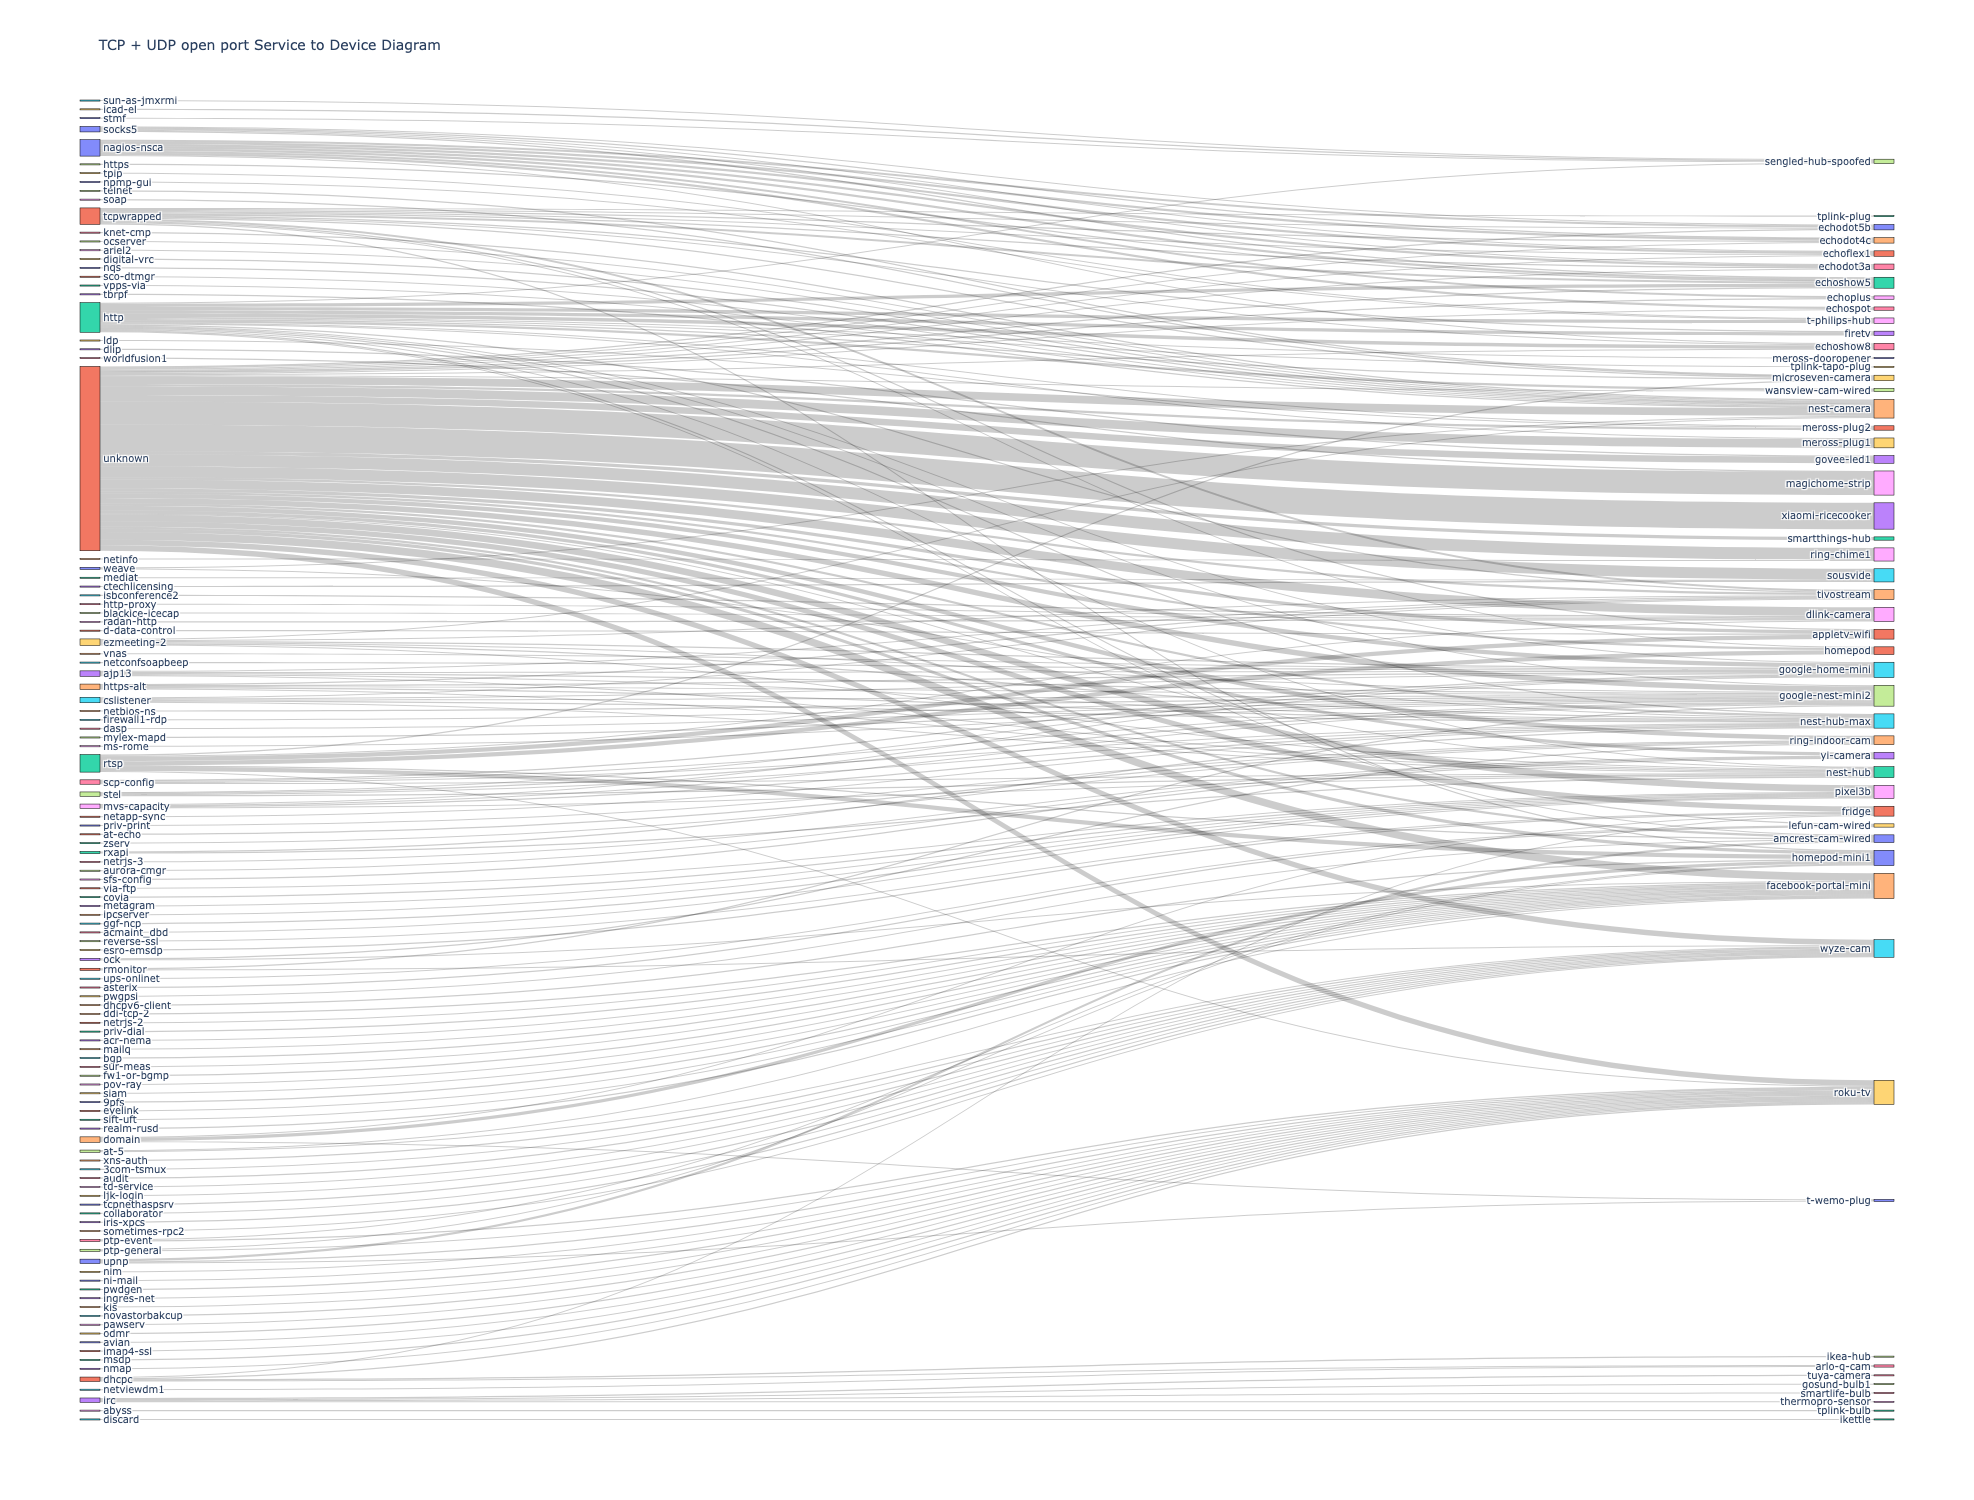

In [228]:
# flow_line_colors = [color_map[conn['service']] for _, conn in connections.iterrows()]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=.5),
        label=labels,
    ),
    link=dict(
        source=[source.index(conn['service']) for _, conn in connections.iterrows()],
        target=[labels.index(conn['device']) for _, conn in connections.iterrows()],
        value=connections['value'].tolist(),
        # color=flow_line_colors,
    )
)])

fig.update_layout(title_text="TCP + UDP open port Service to Device Diagram", font_size=10, height=1500)
fig.show()
# fig.write_image('tcp_services_sankey.pdf')